<a href="https://colab.research.google.com/github/hawa1983/SD/blob/main/2024_L_Line_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Total Delay by Delay Type (2024):

1. **Internal Delays Dominate:** Internal delays caused the highest number of train delays in 2024, with **6,624 trains impacted**, indicating significant operational challenges within the system.

2. **External Delays:** External factors led to **4,807 train delays**, making it the second-largest contributor and emphasizing the impact of external disruptions on service reliability.

3. **Planned ROW Work:** Scheduled Right-of-Way (ROW) work resulted in **2,844 train delays**, reflecting the trade-off between necessary maintenance and service interruptions.

4. **Operating Environment:** Issues related to the operating environment caused delays for **2,195 trains**, showcasing the need to address infrastructure and environmental conditions affecting performance.

5. **Crew Availability:** Crew availability issues resulted in **1,934 train delays**, the lowest category, but still a notable area for improvement in workforce management.

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Changes required for a line
# ----------------------------------------------
# Load the dataset
file_path = 'https://raw.githubusercontent.com/hawa1983/SD/refs/heads/main/L_Incident%20List.csv'  # Replace with your file path

# Define train line
train_line = "L"  # Change as needed
train_line = str(train_line)

# ----------------------------------------------

# Read the file
data = pd.read_csv(file_path)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Ensure 'Line' is consistently string for filtering
data['Line'] = data['Line'].astype(str)
train_line = str(train_line)

# Schedule Rollup
schedule_rollup = "Weekday"

# Interval
start_date = '2024-01-01'
end_date = '2024-12-31'

# ----------------------------------------------

# Delay type
# delay_type = 'Internal'
# data['Delay Type'] = data['Delay Type'].str.strip().str.lower()
delay_type = 'Internal'

In [ ]:
print(data.head())

        Date Schedule Rollup STARS ID                          Station Unique  \
0 2024-01-02         Weekday     A-62       242 St - Van Cortlandt Park (101)   
1 2024-01-02         Weekday     A-63                      Cortlandt St (R25)   
2 2024-01-02         Weekday     A-79                             14 St (132)   
3 2024-01-02         Weekday     A-82  Christopher St - Sheridan Square (133)   
4 2024-01-02         Weekday     A-34                       South Ferry (142)   

          Delay Type                          Delay Category  \
0  Crew Availability                                     NaN   
1           External  Public Conduct, Crime, Police Response   
2           External  Public Conduct, Crime, Police Response   
3           External  Public Conduct, Crime, Police Response   
4           External  Public Conduct, Crime, Police Response   

  Delay Subcategory             Charge Department           Trouble Code  \
0               NaN  Division of Service Delivery   

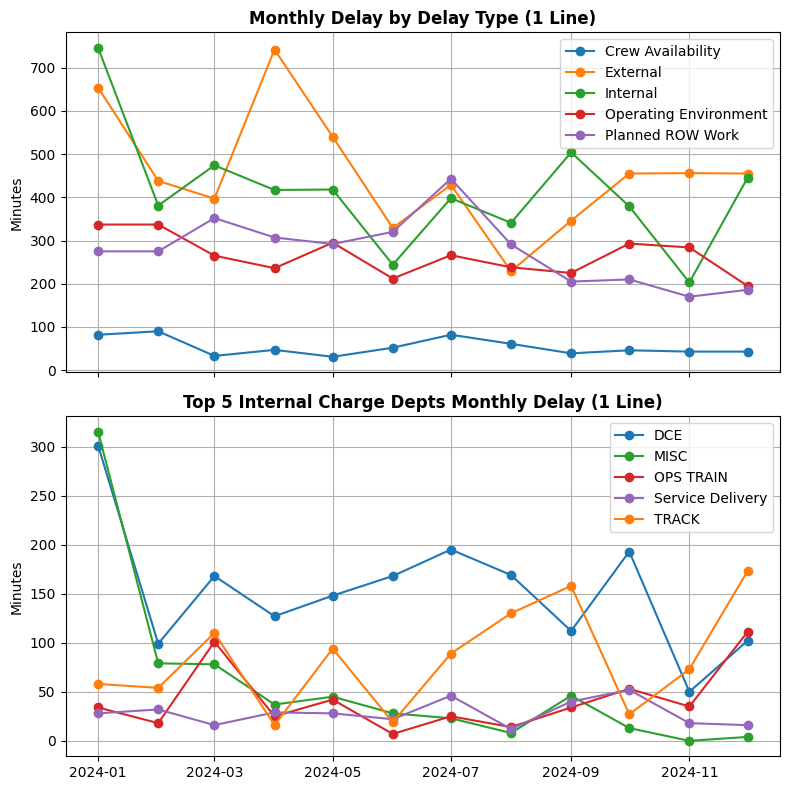

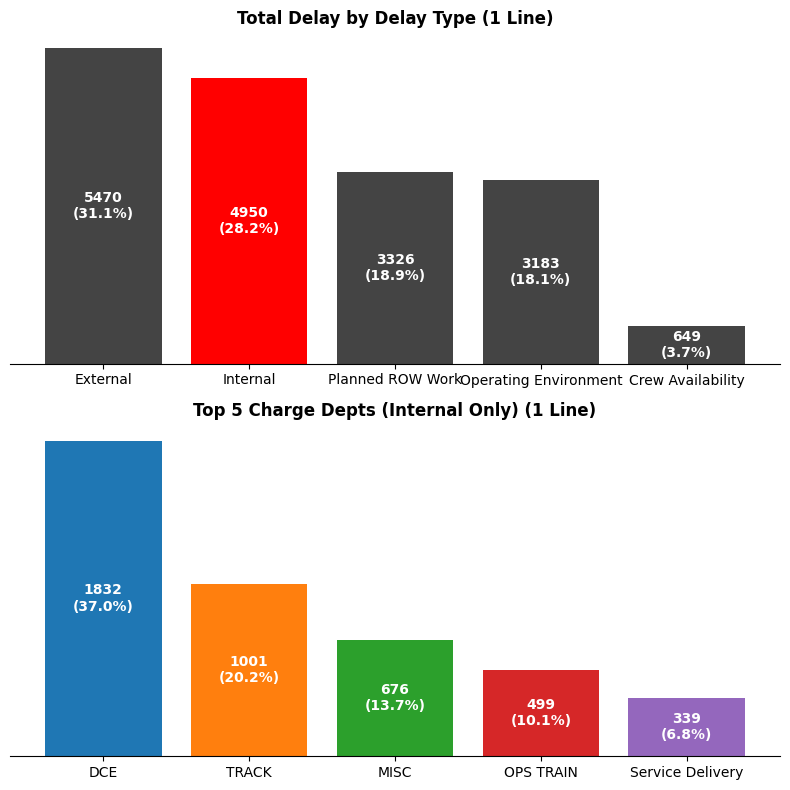

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === CONFIG ===
train_line = 1
schedule_rollup = 'Weekday'
start_date = '2024-01-01'
end_date = '2024-12-31'

# === CLEAN DATA ===
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data['Delay Total'] = pd.to_numeric(data['Delay Total'], errors='coerce')
data['Line'] = data['Line'].astype(str)
train_line = str(train_line)
data = data.dropna(subset=['Date', 'Delay Total'])

# === MAP DEPARTMENTS ===
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery", "Police": "POLICE",
    "Division of MOW Track": "TRACK", "Public": "PUBLIC",
    "Division of MOW Electrical-Signals": "SIGNALS", "Division of Car Equipment": "DCE",
    "Division of Station Environment": "STATIONS", "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG", "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC", "Division of MOW Infrastructure": "MOW INF",
    "Weather": "WEATHER", "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN", "Automatic Train Supervision": "ATS",
    "Division of MOW Electrical-Power": "MOW ELECT-POW", "Electrical": "ELECTRICAL",
    "MTA-IT": "MTA-IT", "Labor Union": "UNION", "Capital Program Management": "CPM",
    "Division of Facilities": "FACILITIES", "CBTC": "CBTC"
}
data['Charge Dept Mapped'] = data['Charge Department'].map(charge_dept_mapping)

# === FILTER DATA ===
filtered = data[
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date) &
    (data['Delay Total'] > 0)
].copy()
filtered['Month'] = filtered['Date'].dt.to_period('M')

# === LINE CHART DATA ===
monthly_by_type = (
    filtered.groupby(['Month', 'Delay Type'])['Delay Total']
    .sum().unstack(fill_value=0)
)
monthly_by_type.index = monthly_by_type.index.to_timestamp()
type_colors = {dt: sns.color_palette("tab10")[i % 10] for i, dt in enumerate(monthly_by_type.columns)}

filtered_internal = filtered[filtered['Delay Type'] == 'Internal']
filtered_internal = filtered_internal.dropna(subset=['Charge Dept Mapped'])
top5_departments = (
    filtered_internal.groupby('Charge Dept Mapped')['Delay Total']
    .sum().nlargest(5).index.tolist()
)
monthly_by_dept = (
    filtered_internal[filtered_internal['Charge Dept Mapped'].isin(top5_departments)]
    .groupby(['Month', 'Charge Dept Mapped'])['Delay Total']
    .sum().unstack(fill_value=0)
)
monthly_by_dept.index = monthly_by_dept.index.to_timestamp()
dept_colors = {dept: sns.color_palette("tab10")[i % 10] for i, dept in enumerate(top5_departments)}

# === BAR CHART DATA ===
summary_type = (
    filtered.groupby('Delay Type')['Delay Total'].sum()
    .reset_index().sort_values(by='Delay Total', ascending=False)
)
total_delay = summary_type['Delay Total'].sum()
summary_type['Percentage'] = summary_type['Delay Total'] / total_delay * 100
summary_type['Color'] = np.where(summary_type['Delay Type'] == 'Internal', '#FF0000', '#444444')

summary_dept = (
    filtered_internal.groupby('Charge Dept Mapped')['Delay Total'].sum()
    .reset_index().dropna()
)
top5_bar = summary_dept.nlargest(5, 'Delay Total').copy()
total_internal = summary_dept['Delay Total'].sum()
top5_bar['Percent Delay'] = top5_bar['Delay Total'] / total_internal * 100
bar_colors = sns.color_palette("tab10", n_colors=5).as_hex()

# === FIGURE 1: LINE CHARTS ===
fig1, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 8), sharex=True)

# --- Delay Type Line Chart ---
for dt in monthly_by_type.columns:
    ax1.plot(monthly_by_type.index, monthly_by_type[dt], marker='o', label=dt, color=type_colors[dt])
ax1.set_title(f'Monthly Delay by Delay Type ({train_line} Line)', fontweight='bold')
ax1.set_ylabel('Minutes')
ax1.legend()
ax1.grid(True)

# --- Internal Charge Dept Line Chart ---
for dept in monthly_by_dept.columns:
    ax2.plot(monthly_by_dept.index, monthly_by_dept[dept], marker='o', label=dept, color=dept_colors[dept])
ax2.set_title(f'Top 5 Internal Charge Depts Monthly Delay ({train_line} Line)', fontweight='bold')
ax2.set_ylabel('Minutes')
ax2.legend()
ax2.grid(True)

fig1.tight_layout()
plt.show()

# === FIGURE 2: BAR CHARTS ===
fig2, (ax3, ax4) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# --- Total Delay by Delay Type ---
bars1 = ax3.bar(summary_type['Delay Type'], summary_type['Delay Total'], color=summary_type['Color'])
ax3.set_title(f'Total Delay by Delay Type ({train_line} Line)', fontweight='bold')
ax3.get_yaxis().set_visible(False)
ax3.spines[['top', 'right', 'left']].set_visible(False)
for bar, val, pct in zip(bars1, summary_type['Delay Total'], summary_type['Percentage']):
    ax3.text(bar.get_x() + bar.get_width()/2, val/2, f"{int(val)}\n({pct:.1f}%)",
             ha='center', va='center', color='white', fontsize=10, fontweight='bold')

# --- Top 5 Internal Charge Departments ---
bars2 = ax4.bar(top5_bar['Charge Dept Mapped'], top5_bar['Delay Total'], color=bar_colors)
ax4.set_title(f'Top 5 Charge Depts (Internal Only) ({train_line} Line)', fontweight='bold')
ax4.get_yaxis().set_visible(False)
ax4.spines[['top', 'right', 'left']].set_visible(False)
for bar, val, pct in zip(bars2, top5_bar['Delay Total'], top5_bar['Percent Delay']):
    ax4.text(bar.get_x() + bar.get_width()/2, val/2, f"{int(val)}\n({pct:.1f}%)",
             ha='center', va='center', color='white', fontsize=10, fontweight='bold')

fig2.tight_layout()
plt.show()


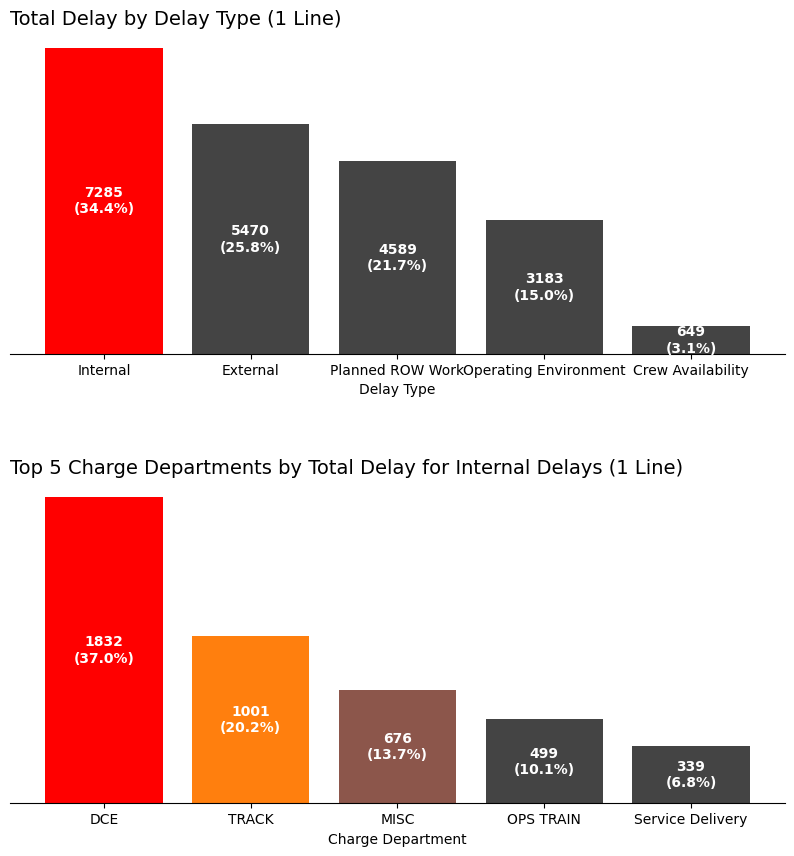

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'Delay Total' is numeric globally
data['Delay Total'] = pd.to_numeric(data['Delay Total'], errors='coerce')

# Ensure 'Line' is consistently string for filtering
data['Line'] = data['Line'].astype(str)
train_line = str(train_line)

# === PLOT 1: Total Delay by Delay Type ===
filtered_data1 = data[(data['Line'] == train_line) & (data['Schedule Rollup'] == schedule_rollup)]
delay_type_summary = filtered_data1.groupby('Delay Type')['Delay Total'].sum().reset_index()

# Reconvert just in case groupby result inherited string
delay_type_summary['Delay Total'] = pd.to_numeric(delay_type_summary['Delay Total'], errors='coerce')

# Total delay across **all** delay types
total_delay1 = data[data['Line'] == train_line]['Delay Total'].sum()

# Percentages
delay_type_summary['Percentage'] = (delay_type_summary['Delay Total'] / total_delay1) * 100
delay_type_summary = delay_type_summary.sort_values(by='Delay Total', ascending=False)
delay_type_summary['Color'] = np.where(delay_type_summary['Delay Type'] == "Internal", "#ff0000", "#444444")

# === PLOT 2: Top 5 Charge Departments by Delay ===
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery", "Police": "POLICE",
    "Division of MOW Track": "TRACK", "Public": "PUBLIC",
    "Division of MOW Electrical-Signals": "SIGNALS", "Division of Car Equipment": "DCE",
    "Division of Station Environment": "STATIONS", "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG", "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC", "Division of MOW Infrastructure": "MOW INF",
    "Weather": "WEATHER", "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN", "Automatic Train Supervision": "ATS",
    "Division of MOW Electrical-Power": "MOW ELECT-POW", "Electrical": "ELECTRICAL",
    "MTA-IT": "MTA-IT", "Labor Union": "UNION", "Capital Program Management": "CPM",
    "Division of Facilities": "FACILITIES", "CBTC": "CBTC"
}

filtered_data2 = data[(data['Delay Type'] == 'Internal') & (data['Line'] == train_line) & (data['Schedule Rollup'] == 'Weekday')]
grouped_data = filtered_data2.groupby('Charge Department')['Delay Total'].sum().reset_index()
grouped_data['Charge Department'] = grouped_data['Charge Department'].map(charge_dept_mapping)
grouped_data = grouped_data.dropna()

grouped_data['Delay Total'] = pd.to_numeric(grouped_data['Delay Total'], errors='coerce')
grouped_data = grouped_data.dropna(subset=['Delay Total'])

# Top 5
displayed_data = grouped_data.nlargest(5, 'Delay Total').copy()
total_delay2 = grouped_data['Delay Total'].sum()
displayed_data['Percent Delay'] = (displayed_data['Delay Total'] / total_delay2) * 100

colors = ['#ff0000', '#ff7f0e', '#8c564b', '#444444', '#444444']

# === CREATE PLOTS ===
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), gridspec_kw={'hspace': 0.4})

# --- First Plot ---
bars1 = axes[0].bar(delay_type_summary['Delay Type'], delay_type_summary['Delay Total'], color=delay_type_summary['Color'])
axes[0].set_xlabel("Delay Type")
axes[0].set_title(f"Total Delay by Delay Type ({train_line} Line)", loc='left', fontsize=14)
axes[0].tick_params(axis='x', rotation=0)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].get_yaxis().set_visible(False)

for bar, value, pct in zip(bars1, delay_type_summary['Delay Total'], delay_type_summary['Percentage']):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height/2,
                 f"{int(value)}\n({pct:.1f}%)",
                 ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# --- Second Plot ---
bars2 = axes[1].bar(displayed_data['Charge Department'], displayed_data['Delay Total'], color=colors)
axes[1].set_xlabel("Charge Department")
axes[1].set_title(f"Top 5 Charge Departments by Total Delay for Internal Delays ({train_line} Line)", loc='left', fontsize=14)
axes[1].tick_params(axis='x', rotation=0)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].get_yaxis().set_visible(False)

for bar, value, pct in zip(bars2, displayed_data['Delay Total'], displayed_data['Percent Delay']):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height/2,
                 f"{int(value)}\n({pct:.1f}%)",
                 ha='center', va='center', fontsize=10, color='white', fontweight='bold')

plt.show()


/tmp/ipython-input-39-453930758.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


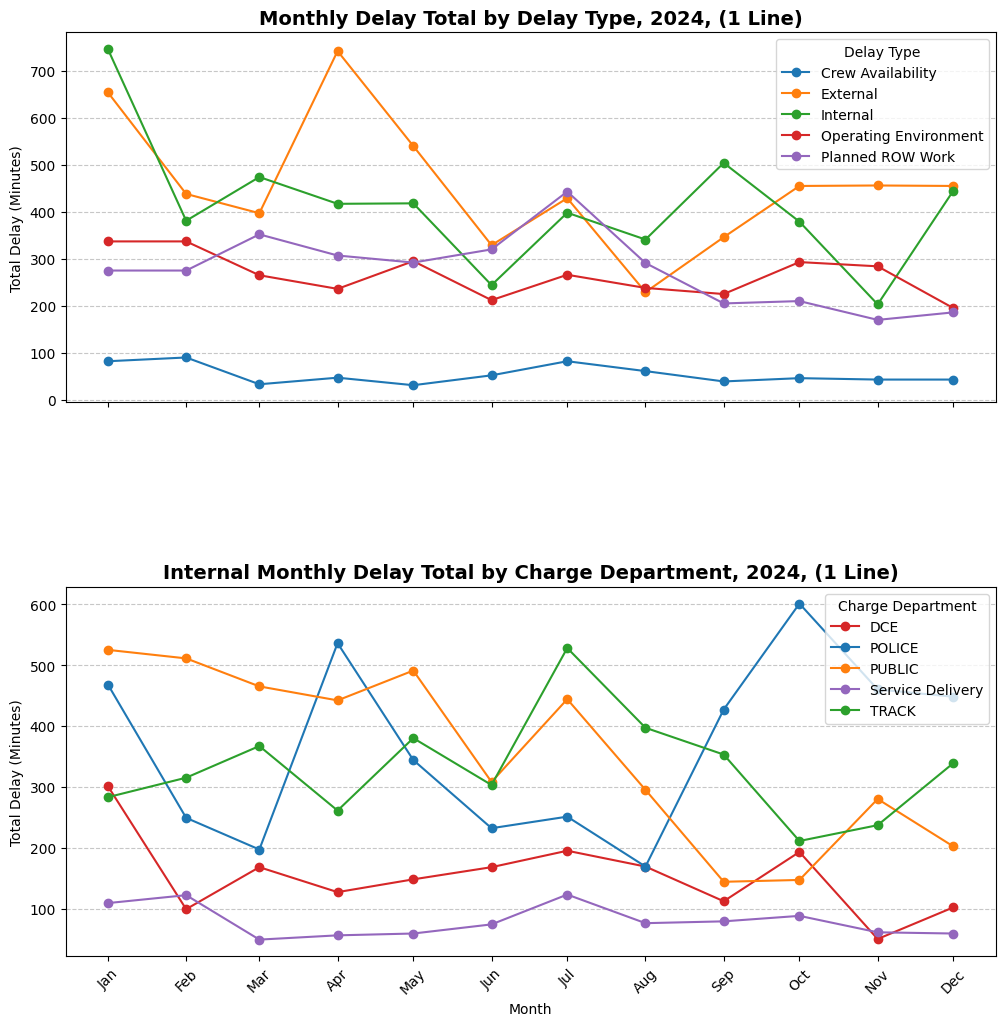

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Clean and Prepare the Data ===
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data['Delay Total'] = pd.to_numeric(data['Delay Total'], errors='coerce')
data = data.dropna(subset=['Date', 'Delay Total'])

# === Step 2: Map Charge Departments ===
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery", "Police": "POLICE",
    "Division of MOW Track": "TRACK", "Public": "PUBLIC",
    "Division of MOW Electrical-Signals": "SIGNALS", "Division of Car Equipment": "DCE",
    "Division of Station Environment": "STATIONS", "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG", "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC", "Division of MOW Infrastructure": "MOW INF",
    "Weather": "WEATHER", "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN", "Automatic Train Supervision": "ATS",
    "Division of MOW Electrical-Power": "MOW ELECT-POW", "Electrical": "ELECTRICAL",
    "MTA-IT": "MTA-IT", "Labor Union": "UNION", "Capital Program Management": "CPM",
    "Division of Facilities": "FACILITIES", "CBTC": "CBTC"
}
data['Charge Dept Mapped'] = data['Charge Department'].map(charge_dept_mapping)
data = data.dropna(subset=['Charge Dept Mapped'])

# === Step 3: Filter Parameters ===
train_line = 1  # Change to appropriate line as int or str
train_line = str(train_line)

schedule_rollup = 'Weekday'
start_date = '2024-01-01'
end_date = '2024-12-31'

filtered = data[
    (data['Line'].astype(str) == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date) &
    (data['Delay Total'] > 0)
].copy()
filtered['Month'] = filtered['Date'].dt.to_period('M')

# === Step 4A: Monthly Delay by Delay Type ===
monthly_by_type = (
    filtered.groupby(['Month', 'Delay Type'])['Delay Total']
    .sum()
    .unstack(fill_value=0)
)
monthly_by_type.index = monthly_by_type.index.to_timestamp()
delay_types = monthly_by_type.columns.tolist()
type_colors = {dt: sns.color_palette("tab10")[i % 10] for i, dt in enumerate(delay_types)}

# === Step 4B: Monthly Delay by Top 5 Departments ===
top5_departments = (
    filtered.groupby('Charge Dept Mapped')['Delay Total']
    .sum()
    .nlargest(5)
    .index.tolist()
)
filtered_top5 = filtered[filtered['Charge Dept Mapped'].isin(top5_departments)]
monthly_by_dept = (
    filtered_top5.groupby(['Month', 'Charge Dept Mapped'])['Delay Total']
    .sum()
    .unstack(fill_value=0)
)
monthly_by_dept.index = monthly_by_dept.index.to_timestamp()
dept_colors = {dept: sns.color_palette("tab10")[i % 10] for i, dept in enumerate(top5_departments)}

# === Step 5: Plot Both Charts ===
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True, gridspec_kw={'hspace': 0.5})

# --- Top Plot: Delay Type ---
for dt in monthly_by_type.columns:
    axes[0].plot(monthly_by_type.index, monthly_by_type[dt], marker='o', label=dt, color=type_colors[dt])
axes[0].set_title(f'Monthly Delay Total by Delay Type, 2024, ({train_line} Line)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Total Delay (Minutes)')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].legend(title='Delay Type', fontsize=10)

# --- Bottom Plot: Charge Department ---
for dept in monthly_by_dept.columns:
    axes[1].plot(monthly_by_dept.index, monthly_by_dept[dept], marker='o', label=dept, color=dept_colors[dept])
axes[1].set_title(f'Internal Monthly Delay Total by Charge Department, 2024, ({train_line} Line)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Delay (Minutes)')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].legend(title='Charge Department', fontsize=10)
axes[1].set_xticks(monthly_by_type.index)
axes[1].set_xticklabels(monthly_by_type.index.strftime('%b'), rotation=45)

plt.tight_layout()
plt.show()


/tmp/ipython-input-32-2937747385.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title='Delay Type', fontsize=10, loc='upper center')
/tmp/ipython-input-32-2937747385.py:131: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(title='Charge Department', fontsize=10, loc='upper center')
/tmp/ipython-input-32-2937747385.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


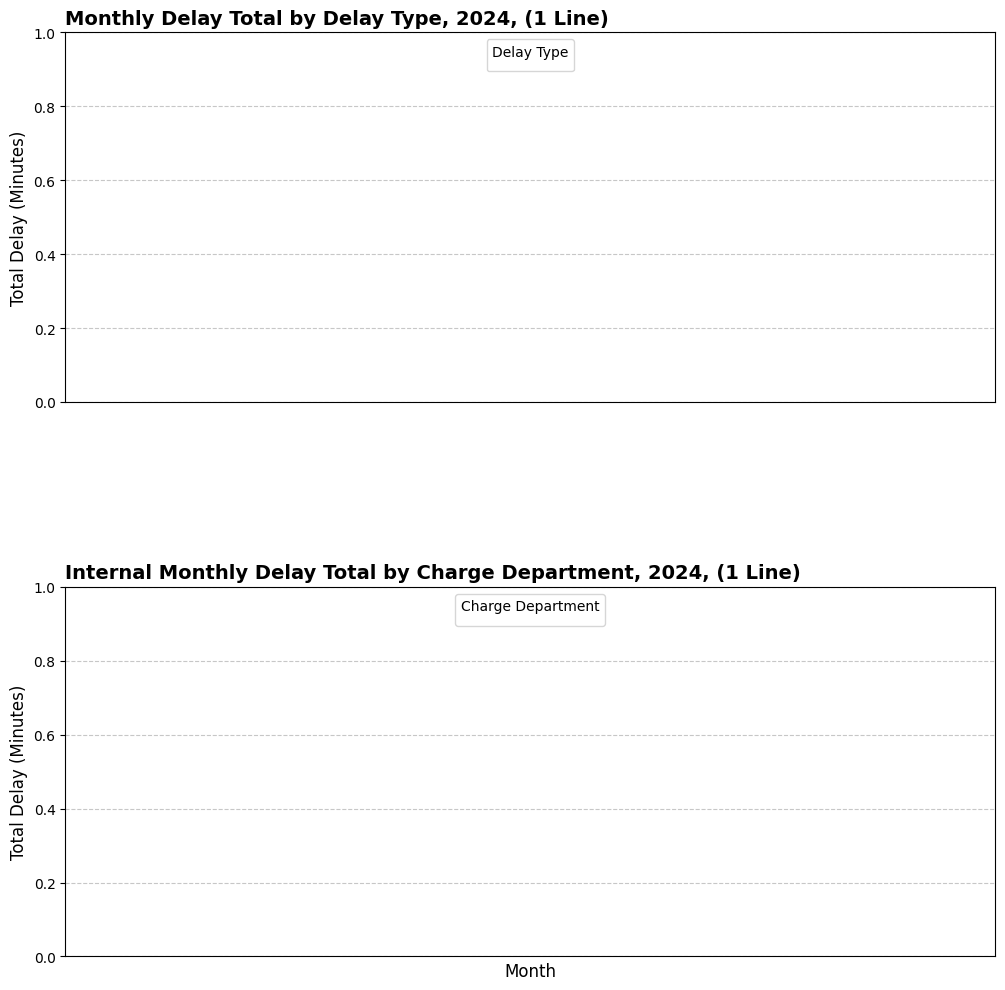

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Ensure Clean Data Types ---
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data['Delay Total'] = pd.to_numeric(data['Delay Total'], errors='coerce')
data = data.dropna(subset=['Date', 'Delay Total'])

data['Line'] = data['Line'].astype(str)
train_line = '1'  # 👈 Change this to match a valid value in your dataset (e.g. 'A', 'C', 'E', etc.)

# --- Normalize Charge Department Names ---
data['Raw Charge Department'] = data['Charge Department']
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Division of MOW Electrical-Signals": "SIGNALS",
    "Division of MOW Signals": "SIGNALS",
    "Division of MOW Track": "TRACK",
    "Division of Car Equipment": "DCE",
    "Miscellaneous": "MISC",
    "OPS Training": "OPS TRAIN"
}
data['Charge Department'] = data['Raw Charge Department'].map(charge_dept_mapping)
data = data.dropna(subset=['Charge Department'])

# --- Define Filter Parameters ---
schedule_rollup = "Weekday"
start_date = '2024-01-01'
end_date = '2024-12-31'
delay_type = 'Internal'

# === PLOT 1: Monthly Delay by Delay Type ===
filtered_data_type = data[
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date) &
    (data['Delay Total'] > 0)
].copy()

filtered_data_type['Month'] = filtered_data_type['Date'].dt.to_period('M')
monthly_delay_by_type = (
    filtered_data_type
    .groupby(['Month', 'Delay Type'])['Delay Total']
    .sum()
    .unstack(fill_value=0)
)
monthly_delay_by_type.index = monthly_delay_by_type.index.to_timestamp()

# === PLOT 2: Monthly Delay by Top 5 Internal Charge Departments ===
top_departments = (
    data[
        (data['Line'] == train_line) &
        (data['Schedule Rollup'] == schedule_rollup) &
        (data['Date'] >= start_date) & (data['Date'] <= end_date) &
        (data['Delay Type'] == delay_type)
    ]
    .groupby('Charge Department')['Delay Total']
    .sum()
    .nlargest(5)
    .index.tolist()
)

filtered_data_department = data[
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date) &
    (data['Delay Type'] == delay_type) &
    (data['Charge Department'].isin(top_departments)) &
    (data['Delay Total'] > 0)
].copy()

filtered_data_department['Month'] = filtered_data_department['Date'].dt.to_period('M')
monthly_delay_by_department = (
    filtered_data_department
    .groupby(['Month', 'Charge Department'])['Delay Total']
    .sum()
    .unstack(fill_value=0)
)
monthly_delay_by_department.index = monthly_delay_by_department.index.to_timestamp()

import seaborn as sns

# Create separate color pools
delay_colors = sns.color_palette("Set2", n_colors=len(monthly_delay_by_type.columns)).as_hex()
dept_colors = sns.color_palette("Set1", n_colors=len(top_departments)).as_hex()

# Assign unique colors to delay types
custom_colors_type = {
    dtype: delay_colors[i % len(delay_colors)]
    for i, dtype in enumerate(monthly_delay_by_type.columns)
}

# Assign unique colors to departments
custom_colors_department = {
    dept: dept_colors[i % len(dept_colors)]
    for i, dept in enumerate(top_departments)
}


# === CREATE LINE PLOTS ===
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True, gridspec_kw={'hspace': 0.5})

# --- Plot 1: Delay Types ---
for dt in monthly_delay_by_type.columns:
    axes[0].plot(
        monthly_delay_by_type.index,
        monthly_delay_by_type[dt],
        marker='o',
        label=dt,
        color=custom_colors_type.get(dt, "#444444")
    )
axes[0].set_title(f'Monthly Delay Total by Delay Type, 2024, ({train_line} Line)', fontsize=14, loc='left', fontweight='bold')
axes[0].set_ylabel('Total Delay (Minutes)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].legend(title='Delay Type', fontsize=10, loc='upper center')

# --- Plot 2: Charge Departments ---
for dept in monthly_delay_by_department.columns:
    axes[1].plot(
        monthly_delay_by_department.index,
        monthly_delay_by_department[dept],
        marker='o',
        label=dept,
        color=custom_colors_department.get(dept, "#444444")
    )
axes[1].set_title(f'Internal Monthly Delay Total by Charge Department, 2024, ({train_line} Line)', fontsize=14, loc='left', fontweight='bold')
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Total Delay (Minutes)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].legend(title='Charge Department', fontsize=10, loc='upper center')

months = monthly_delay_by_type.index
axes[1].set_xticks(months)
axes[1].set_xticklabels(months.strftime('%b'), rotation=45, fontsize=10)

plt.tight_layout()
plt.show()


/tmp/ipython-input-27-2702116006.py:117: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title='Delay Type', fontsize=10, loc='upper center')
/tmp/ipython-input-27-2702116006.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(title='Charge Department', fontsize=10, loc='upper center')
/tmp/ipython-input-27-2702116006.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


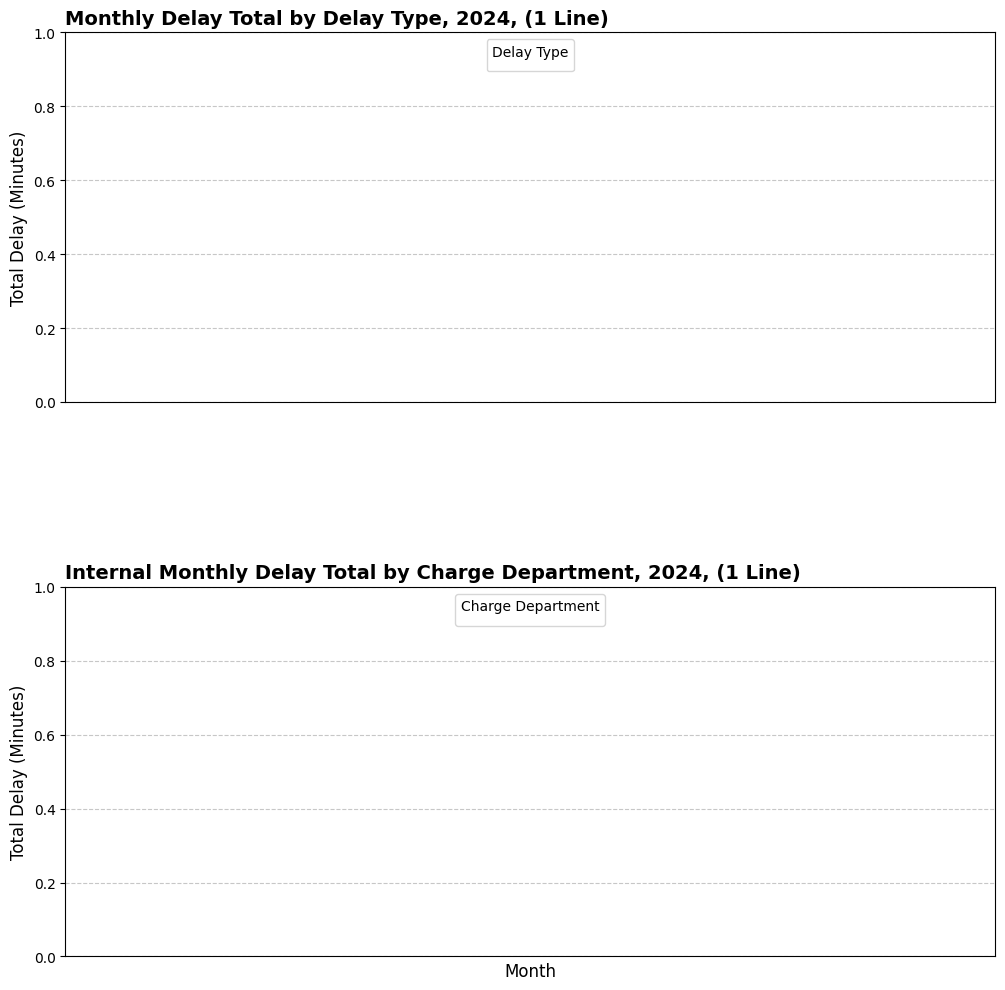

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preserve original Charge Department
data['Raw Charge Department'] = data['Charge Department']

# Map short names
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Division of MOW Electrical-Signals": "SIGNALS",
    "Division of MOW Signals": "SIGNALS",
    "Division of MOW Track": "TRACK",
    "Division of Car Equipment": "DCE",
    "Miscellaneous": "MISC",
    "OPS Training": "OPS TRAIN"
}
data['Charge Department'] = data['Raw Charge Department'].map(charge_dept_mapping)
data = data.dropna(subset=['Charge Department'])  # Drop unmapped depts

# Convert Delay Total to numeric if needed
data['Delay Total'] = pd.to_numeric(data['Delay Total'], errors='coerce')
data = data.dropna(subset=['Delay Total'])

# Parameters
schedule_rollup = "Weekday"
start_date = '2024-01-01'
end_date = '2024-12-31'
delay_type = 'Internal'
train_line = str(train_line)  # Ensure train_line is string
data['Line'] = data['Line'].astype(str)

# === Plot 1: Monthly Delay by Delay Type ===
filtered_data_type = data[
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date) &
    (data['Delay Total'] > 0)
].copy()

filtered_data_type['Month'] = filtered_data_type['Date'].dt.to_period('M')
monthly_delay_by_type = (
    filtered_data_type
    .groupby(['Month', 'Delay Type'])['Delay Total']
    .sum()
    .unstack(fill_value=0)
)
monthly_delay_by_type.index = monthly_delay_by_type.index.to_timestamp()

custom_colors_type = {
    "Internal": "#FF0000",
    "External": "#555555",
    "Planned ROW Work": "#FF8C00",
    "Crew Availability": "#FFD700",
    "Operating Environment": "#8B0000"
}

# === Plot 2: Monthly Delay by Top 5 Internal Charge Departments ===

# Step 1: Get top 5 charge departments by internal delay
top_departments = (
    data[
        (data['Line'] == train_line) &
        (data['Schedule Rollup'] == schedule_rollup) &
        (data['Date'] >= start_date) & (data['Date'] <= end_date) &
        (data['Delay Type'] == delay_type)
    ]
    .groupby('Charge Department')['Delay Total']
    .sum()
    .nlargest(5)
    .index.tolist()
)

# Step 2: Filter only those top 5 departments
filtered_data_department = data[
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date) &
    (data['Delay Type'] == delay_type) &
    (data['Charge Department'].isin(top_departments)) &
    (data['Delay Total'] > 0)
].copy()

filtered_data_department['Month'] = filtered_data_department['Date'].dt.to_period('M')
monthly_delay_by_department = (
    filtered_data_department
    .groupby(['Month', 'Charge Department'])['Delay Total']
    .sum()
    .unstack(fill_value=0)
)
monthly_delay_by_department.index = monthly_delay_by_department.index.to_timestamp()

# Optional: define custom colors (auto fallback to gray for unmapped)
custom_colors_department = {
    "DCE": "#FF0000",
    "TRACK": "#FF8C00",
    "MISC": "#8B0000",
    "OPS TRAIN": "#555555",
    "Service Delivery": "#FFD700"
}

# === Create Plots ===
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True, gridspec_kw={'hspace': 0.5})

# --- Plot 1: Delay Type ---
for dt in monthly_delay_by_type.columns:
    axes[0].plot(
        monthly_delay_by_type.index,
        monthly_delay_by_type[dt],
        marker='o',
        label=dt,
        color=custom_colors_type.get(dt, "#444444")
    )
axes[0].set_title(f'Monthly Delay Total by Delay Type, 2024, ({train_line} Line)', fontsize=14, loc='left', fontweight='bold')
axes[0].set_ylabel('Total Delay (Minutes)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].legend(title='Delay Type', fontsize=10, loc='upper center')

# --- Plot 2: Charge Department ---
for dept in monthly_delay_by_department.columns:
    axes[1].plot(
        monthly_delay_by_department.index,
        monthly_delay_by_department[dept],
        marker='o',
        label=dept,
        color=custom_colors_department.get(dept, "#444444")
    )
axes[1].set_title(f'Internal Monthly Delay Total by Charge Department, 2024, ({train_line} Line)', fontsize=14, loc='left', fontweight='bold')
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Total Delay (Minutes)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].legend(title='Charge Department', fontsize=10, loc='upper center')

# Format x-axis
months = monthly_delay_by_type.index
axes[1].set_xticks(months)
axes[1].set_xticklabels(months.strftime('%b'), rotation=45, fontsize=10)

plt.tight_layout()
plt.show()


/tmp/ipython-input-28-455443608.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title='Delay Type', fontsize=10, loc='upper center')
/tmp/ipython-input-28-455443608.py:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(title='Charge Department', fontsize=10, loc='upper center')
/tmp/ipython-input-28-455443608.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


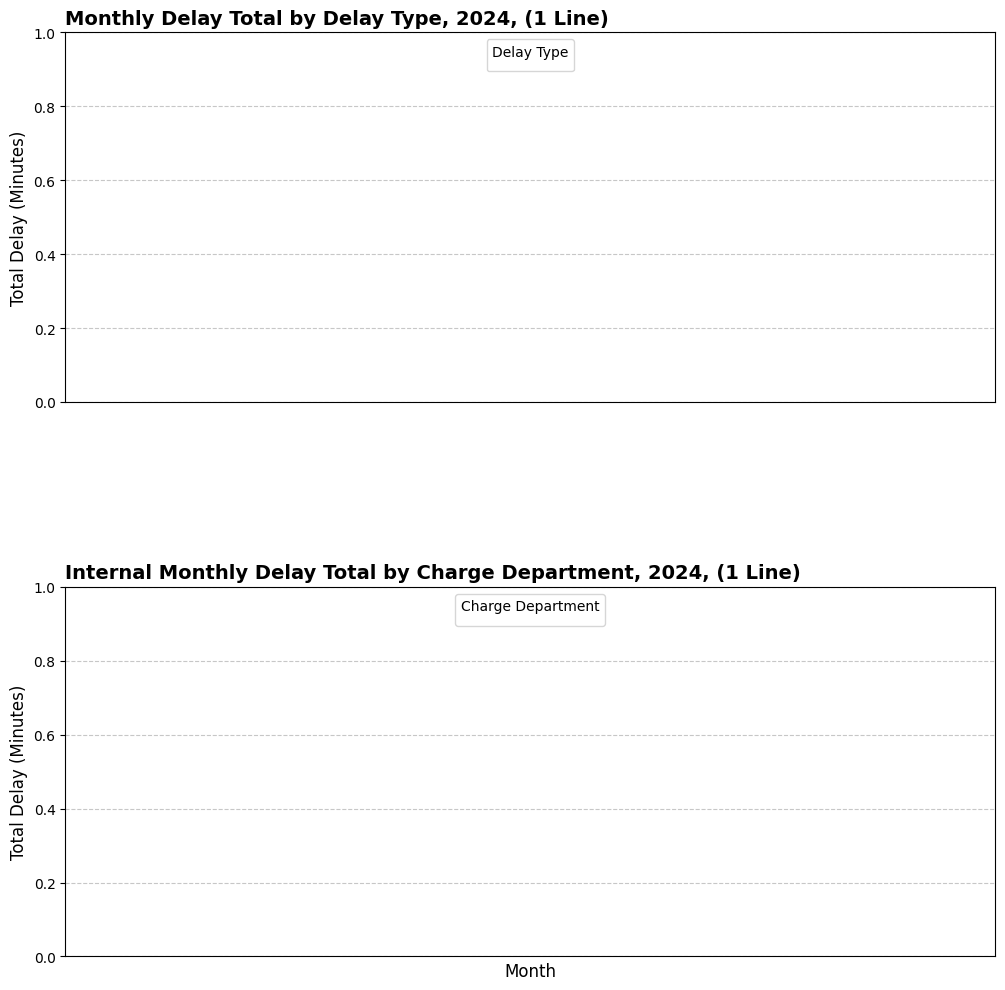

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preserve original Charge Department
data['Raw Charge Department'] = data['Charge Department']

# Map short names
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Division of MOW Electrical-Signals": "SIGNALS",
    "Division of MOW Signals": "SIGNALS",
    "Division of MOW Track": "TRACK",
    "Division of Car Equipment": "DCE",
    "Miscellaneous": "MISC"
}
data['Charge Department'] = data['Raw Charge Department'].map(charge_dept_mapping)

# Parameters

schedule_rollup = "Weekday"
start_date = '2024-01-01'
end_date = '2024-12-31'
delay_type = 'Internal'

# --- Filter data for Delay Type (Plot 1) ---
filtered_data_type = data[
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date) &
    (data['Delay Total'] > 0)
].copy()

# Add month column
filtered_data_type['Month'] = filtered_data_type['Date'].dt.to_period('M')
monthly_delay_by_type = filtered_data_type.groupby(['Month', 'Delay Type'])['Delay Total'].sum().unstack(fill_value=0)
monthly_delay_by_type.index = monthly_delay_by_type.index.to_timestamp()

# Custom colors for delay types
custom_colors_type = {
    "Internal": "#FF0000",
    "External": "#555555",
    "Planned ROW Work": "#FF8C00",
    "Crew Availability": "#FFD700",
    "Operating Environment": "#8B0000"
}

# --- Filter data for Charge Department (Plot 2) ---
filtered_data_department = data[
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date) &
    (data['Delay Type'] == delay_type) &
    (data['Charge Department'].isin(["SIGNALS", "DCE", "TRACK", "Service Delivery", "MISC"])) &
    (data['Delay Total'] > 0)
].copy()

# Add month column
filtered_data_department['Month'] = filtered_data_department['Date'].dt.to_period('M')
monthly_delay_by_department = filtered_data_department.groupby(['Month', 'Charge Department'])['Delay Total'].sum().unstack(fill_value=0)
monthly_delay_by_department.index = monthly_delay_by_department.index.to_timestamp()

# Custom colors for departments
custom_colors_department = {
    "SIGNALS": "#FF0000",
    "DCE": "#FF8C00",
    "TRACK": "#8B0000",
    "Service Delivery": "#FFD700",
    "MISC": "#555555"
}

# --- Create Plots ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True, gridspec_kw={'hspace': 0.5})

# Plot 1: Monthly Delay by Delay Type
for dt in monthly_delay_by_type.columns:
    axes[0].plot(
        monthly_delay_by_type.index,
        monthly_delay_by_type[dt],
        marker='o',
        label=dt,
        color=custom_colors_type.get(dt, "#444444")
    )
axes[0].set_title(f'Monthly Delay Total by Delay Type, 2024, ({train_line} Line)', fontsize=14, loc='left', fontweight='bold')
axes[0].set_ylabel('Total Delay (Minutes)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].legend(title='Delay Type', fontsize=10, loc='upper center')

# Plot 2: Monthly Delay by Charge Department
for dept in monthly_delay_by_department.columns:
    axes[1].plot(
        monthly_delay_by_department.index,
        monthly_delay_by_department[dept],
        marker='o',
        label=dept,
        color=custom_colors_department.get(dept, "#444444")
    )
axes[1].set_title(f'Internal Monthly Delay Total by Charge Department, 2024, ({train_line} Line)', fontsize=14, loc='left', fontweight='bold')
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Total Delay (Minutes)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].legend(title='Charge Department', fontsize=10, loc='upper center')

# Format x-axis months
months = monthly_delay_by_type.index
axes[1].set_xticks(months)
axes[1].set_xticklabels(months.strftime('%b'), rotation=45, fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the dataset
file_path = 'Q_Incident_List.csv'
data = pd.read_csv(file_path)

# Convert 'Incident Time' to datetime
data['Incident Time'] = pd.to_datetime(data['Incident Time'], errors='coerce')

# Create fractional hour column
data['FractionalHour'] = data['Incident Time'].dt.hour + data['Incident Time'].dt.minute / 60.0

# Define peak periods
def assign_period(hour):
    if 0.0 <= hour < 6.0:
        return 'Mid Night'
    elif 6.0 <= hour < 10.0:
        return 'AM Peak'
    elif 10.0 <= hour < 15.0:
        return 'Mid Day'
    elif 15.0 <= hour < 19.0:
        return 'PM Peak'
    elif 19.0 <= hour < 24.0:
        return 'Evening'
    return None

# Assign period
data['Period'] = data['FractionalHour'].apply(assign_period)

# Filter data
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == 'Q') &
    (data['Schedule Rollup'] == 'Weekday')
]

# Ensure 'Delay Total' is numeric
filtered_data['Delay Total'] = pd.to_numeric(filtered_data['Delay Total'], errors='coerce').fillna(0)

# Group by Period and Charge Department and sum the Delay Total
grouped = filtered_data.groupby(['Period', 'Charge Department'])['Delay Total'].sum().unstack(fill_value=0)

# Get top 5 charge departments by total delay
top5 = grouped.sum().nlargest(5).index
grouped = grouped[top5]

# Reorder periods
ordered_periods = ['Mid Night', 'AM Peak', 'Mid Day', 'PM Peak', 'Evening']
grouped = grouped.reindex(ordered_periods)

# Custom color spectrum
custom_colors = ['#ff0000', '#ff7f0e', '#8c564b', '#4d4d4d', '#595959']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
grouped.plot(kind='bar', stacked=True, color=custom_colors, width=0.9, alpha=0.95, ax=ax)

# Annotate bar segments
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        r, g, b, _ = mcolors.to_rgba(bar.get_facecolor())
        brightness = r * 0.299 + g * 0.587 + b * 0.114
        text_color = 'white' if brightness < 0.5 else 'black'
        ax.text(x, y, int(height), ha='center', va='center', fontsize=9, color=text_color, fontweight='bold')

# Title and labels
ax.set_title("Top 5 Charge Departments by Total Delay Across Time Periods (Q Line – Weekdays)", fontsize=14, fontweight='bold', loc='left')
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Total Delay (Minutes)', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title='Charge Department', bbox_to_anchor=(0.7, 1), loc='upper left', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Q_Incident_List.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the dataset
file_path = 'Q_Incident_List.csv'
data = pd.read_csv(file_path)

# Convert 'Incident Time' to datetime
data['Incident Time'] = pd.to_datetime(data['Incident Time'], errors='coerce')

# Create fractional hour column
data['FractionalHour'] = data['Incident Time'].dt.hour + data['Incident Time'].dt.minute / 60.0

# Define peak periods
def assign_period(hour):
    if 0.0 <= hour < 6.0:
        return 'Mid Night'
    elif 6.0 <= hour < 10.0:
        return 'AM Peak'
    elif 10.0 <= hour < 15.0:
        return 'Mid Day'
    elif 15.0 <= hour < 19.0:
        return 'PM Peak'
    elif 19.0 <= hour < 24.0:
        return 'Evening'
    return None

# Assign period
data['Period'] = data['FractionalHour'].apply(assign_period)

# Filter data
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == 'Q') &
    (data['Schedule Rollup'] == 'Weekday')
]

# Group by Period and Charge Department
grouped = filtered_data.groupby(['Period', 'Charge Department']).size().unstack(fill_value=0)

# Get top 5 charge departments
top5 = grouped.sum().nlargest(5).index
grouped = grouped[top5]

# Reorder periods
ordered_periods = ['Mid Night', 'AM Peak', 'Mid Day', 'PM Peak', 'Evening']
grouped = grouped.reindex(ordered_periods)

# Custom color spectrum (based on your visual style)
custom_colors = ['#ff0000', '#ff7f0e', '#8c564b', '#4d4d4d', '#595959']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
grouped.plot(kind='bar', stacked=True, color=custom_colors, width=0.9, alpha=0.95, ax=ax)

# Annotate bar segments
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        r, g, b, _ = mcolors.to_rgba(bar.get_facecolor())
        brightness = r * 0.299 + g * 0.587 + b * 0.114
        text_color = 'white' if brightness < 0.5 else 'black'
        ax.text(x, y, int(height), ha='center', va='center', fontsize=9, color=text_color, fontweight='bold')

# Title and labels
ax.set_title("Top 5 Charge Departments by Incident Count Across Time Periods (Q Line – Weekdays)", fontsize=14, fontweight='bold', loc='left')
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Incident Count', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title='Charge Department', bbox_to_anchor=(0.7, 1), loc='upper left', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Parameters
charge_department = 'SIGNALS'

# Filter the data
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# Group and calculate metrics
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']
top_10 = trouble_code_data.nlargest(5, 'Delay_Total').copy()

# Color bucketing
q75 = top_10['Delay_Per_Incident'].quantile(0.75)
q25 = top_10['Delay_Per_Incident'].quantile(0.25)

top_10['Color'] = top_10['Delay_Per_Incident'].apply(
    lambda x: '#FF0000' if x > q75 else ('#FFA500' if x > q25 else '#333333')
)

# Sort by total delay for plot order
top_10 = top_10.sort_values(by='Delay_Total', ascending=True)

# --- Plot ---
plt.figure(figsize=(12, 8))
bars = plt.barh(
    top_10['Trouble Code'],
    top_10['Delay_Total'],
    color=top_10['Color'],
    edgecolor='black'
)

# Annotate centroid with Delay Total (contrast font color)
for bar, delay in zip(bars, top_10['Delay_Total']):
    x = bar.get_width() / 2
    y = bar.get_y() + bar.get_height() / 2
    r, g, b = bar.get_facecolor()[:3]
    brightness = r * 0.299 + g * 0.587 + b * 0.114
    text_color = 'white' if brightness < 0.5 else 'black'
    plt.text(
        x, y,
        f"{int(delay)} trains",
        ha='center',
        va='center',
        fontsize=10,
        fontweight='bold',
        color=text_color
    )

# Annotate end of bar with incident count
for bar, count in zip(bars, top_10['Incident_Count']):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(
        x + 2, y,
        f"{count} incidents",
        ha='left',
        va='center',
        fontsize=9,
        color='black',
        fontweight='bold'
    )

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='s', color='#FF0000', label='High Delay/Incident'),
    plt.Line2D([0], [0], marker='s', color='#FFA500', label='Medium'),
    plt.Line2D([0], [0], marker='s', color='#333333', label='Low')
]
plt.legend(handles=legend_elements, title='Delay/Incident', loc='lower right')

# Layout
plt.title(f"Top 5 Trouble Codes by Total Delay ({charge_department})", loc='left', fontsize=14, fontweight='bold')
plt.xlabel("Total Delay (Minutes)", fontsize=12)
plt.ylabel("Trouble Code", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the file
data = pd.read_csv(file_path)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# ----------------------------------------------
charge_department = 'Division of MOW Signals'

# --- Filter the Data ---
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# --- Group and Calculate Metrics ---
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']

# --- Prepare Top 5 by Delay per Incident ---
top5 = trouble_code_data.nlargest(5, 'Delay_Per_Incident').copy()
top5 = top5.sort_values(by='Delay_Per_Incident', ascending=False).reset_index(drop=True)

# --- Plot ---
x = np.arange(len(top5))
width = 0.4

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar: Avg Delay per Incident
bars1 = ax1.bar(x, top5['Delay_Per_Incident'], width, label='Avg Delay per Incident', color='#FF5733')
ax1.set_ylabel("Avg Delay per Incident (Minutes)")
ax1.set_xticks(x)
ax1.set_xticklabels(top5['Trouble Code'], rotation=30, ha='right', fontsize=8)
ax1.set_title(f"Top 5 Trouble Codes by Delay per Incident ({charge_department})", loc='left', fontsize=14, fontweight='bold')

# Annotate each bar with:
# (1) Avg delay
# (2) Incident count below or inside the bar
for i, bar in enumerate(bars1):
    delay = bar.get_height()
    count = top5.loc[i, 'Incident_Count']

    # Avg Delay (on top)
    ax1.text(bar.get_x() + bar.get_width() / 2, delay + 0.3,
             f"{delay:.1f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Incident Count (inside or below the bar)
    ax1.text(bar.get_x() + bar.get_width() / 2, delay / 2,
             f"{count} incidents", ha='center', va='center', fontsize=8, color='white', fontweight='bold', rotation=90)

# Legend
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Read the file
data = pd.read_csv(file_path)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# ----------------------------------------------

# # Define train line
train_line = "Q"  # Change as needed
charge_department = 'Division of MOW Signals'

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group by Trouble Code and Station Unique
stacked_data = filtered_data.groupby(['Station Unique', 'Trouble Code']).size().unstack(fill_value=0)

# Filter to include only occurrences greater than 1
stacked_data = stacked_data.loc[:, (stacked_data > 1).any(axis=0)]
stacked_data = stacked_data.loc[(stacked_data > 1).any(axis=1)]

# Sort the locations and trouble codes based on totals
stacked_data = stacked_data.loc[:, stacked_data.sum(axis=0).sort_values(ascending=False).index]
stacked_data = stacked_data.loc[stacked_data.sum(axis=1).sort_values(ascending=False).index]

# Plot the stacked bar chart with warm colors
plt.figure(figsize=(14, 8))
ax = stacked_data.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='OrRd', edgecolor='black')  # Warm colormap

# Add annotations for each bar segment
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:  # Annotate all segments, even those <= 1
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        bar_color = bar.get_facecolor()

        # Determine annotation color based on contrast
        r, g, b, _ = mcolors.to_rgba(bar_color)
        brightness = (r * 0.299 + g * 0.587 + b * 0.114)
        text_color = 'white' if brightness < 0.5 else 'black'

        ax.text(x, y, int(height), ha='center', va='center', fontsize=9, color=text_color, fontweight='bold')

# Customize plot labels and legend
plt.title(f'Trouble Code Prevalence by Location ({charge_department})', fontsize=14, loc='left', fontweight='regular')
plt.xlabel('Station Unique', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Trouble Code', bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove unnecessary borders and y-axis for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the file
data = pd.read_csv(file_path)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# ----------------------------------------------
# Parameters
charge_department = 'Division of MOW Track'

# Filter the data
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# Group and calculate metrics
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']
top_10 = trouble_code_data.nlargest(5, 'Delay_Total').copy()

# Color bucketing
q75 = top_10['Delay_Per_Incident'].quantile(0.75)
q25 = top_10['Delay_Per_Incident'].quantile(0.25)

top_10['Color'] = top_10['Delay_Per_Incident'].apply(
    lambda x: '#FF0000' if x > q75 else ('#FFA500' if x > q25 else '#333333')
)

# Sort by total delay for plot order
top_10 = top_10.sort_values(by='Delay_Total', ascending=True)

# --- Plot ---
plt.figure(figsize=(12, 8))
bars = plt.barh(
    top_10['Trouble Code'],
    top_10['Delay_Total'],
    color=top_10['Color'],
    edgecolor='black'
)

# Annotate centroid with Delay Total (contrast font color)
for bar, delay in zip(bars, top_10['Delay_Total']):
    x = bar.get_width() / 2
    y = bar.get_y() + bar.get_height() / 2
    r, g, b = bar.get_facecolor()[:3]
    brightness = r * 0.299 + g * 0.587 + b * 0.114
    text_color = 'white' if brightness < 0.5 else 'black'
    plt.text(
        x, y,
        f"{int(delay)} trains",
        ha='center',
        va='center',
        fontsize=10,
        fontweight='bold',
        color=text_color
    )

# Annotate end of bar with incident count
for bar, count in zip(bars, top_10['Incident_Count']):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(
        x + 2, y,
        f"{count} incidents",
        ha='left',
        va='center',
        fontsize=9,
        color='black',
        fontweight='bold'
    )

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='s', color='#FF0000', label='High Delay/Incident'),
    plt.Line2D([0], [0], marker='s', color='#FFA500', label='Medium'),
    plt.Line2D([0], [0], marker='s', color='#333333', label='Low')
]
plt.legend(handles=legend_elements, title='Delay/Incident', loc='lower right')

# Layout
plt.title(f"Top 5 Trouble Codes by Total Delay ({charge_department})", loc='left', fontsize=14, fontweight='bold')
plt.xlabel("Total Delay (Minutes)", fontsize=12)
plt.ylabel("Trouble Code", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the file
data = pd.read_csv(file_path)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# ----------------------------------------------
# Parameters
charge_department = 'Division of MOW Track'

# --- Filter the Data ---
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# --- Group and Calculate Metrics ---
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']

# --- Prepare Top 5 by Delay per Incident ---
top5 = trouble_code_data.nlargest(5, 'Delay_Per_Incident').copy()
top5 = top5.sort_values(by='Delay_Per_Incident', ascending=False).reset_index(drop=True)

# --- Plot ---
x = np.arange(len(top5))
width = 0.4

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar: Avg Delay per Incident
bars1 = ax1.bar(x, top5['Delay_Per_Incident'], width, label='Avg Delay per Incident', color='#FF5733')
ax1.set_ylabel("Avg Delay (Trains)")
ax1.set_xticks(x)
ax1.set_xticklabels(top5['Trouble Code'], rotation=30, ha='right', fontsize=8)
ax1.set_title(f"Top 5 Trouble Codes: Delay per Incident vs. Frequency ({charge_department})", loc='left', fontsize=14, fontweight='bold')

# Secondary axis for annotation only (no bars)
ax2 = ax1.twinx()
ax2.set_ylabel("Incident Count")
ax2.set_ylim(0, top5['Incident_Count'].max() * 1.2)  # Add padding for labels

# --- Annotate Avg Delay per Incident ---
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 0.3,
             f"{height:.1f}", ha='center', va='bottom', fontsize=9, fontweight='bold')



# Legend
ax1.legend([bars1], ['Avg Delay per Incident'], loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the file
data = pd.read_csv(file_path)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# ----------------------------------------------
charge_department = 'Division of MOW Track'

# --- Filter the Data ---
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# --- Group and Calculate Metrics ---
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']

# --- Prepare Top 5 by Delay per Incident ---
top5 = trouble_code_data.nlargest(5, 'Delay_Per_Incident').copy()
top5 = top5.sort_values(by='Delay_Per_Incident', ascending=False).reset_index(drop=True)

# --- Plot ---
x = np.arange(len(top5))
width = 0.4

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar: Avg Delay per Incident
bars1 = ax1.bar(x, top5['Delay_Per_Incident'], width, label='Avg Delay per Incident', color='#FF5733')
ax1.set_ylabel("Avg Delay per Incident (Minutes)")
ax1.set_xticks(x)
ax1.set_xticklabels(top5['Trouble Code'], rotation=30, ha='right', fontsize=8)
ax1.set_title(f"Top 5 Trouble Codes by Delay per Incident ({charge_department})", loc='left', fontsize=14, fontweight='bold')

# Annotate each bar with:
# (1) Avg delay
# (2) Incident count below or inside the bar
for i, bar in enumerate(bars1):
    delay = bar.get_height()
    count = top5.loc[i, 'Incident_Count']

    # Avg Delay (on top)
    ax1.text(bar.get_x() + bar.get_width() / 2, delay + 0.3,
             f"{delay:.1f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Incident Count (inside or below the bar)
    ax1.text(bar.get_x() + bar.get_width() / 2, delay / 2,
             f"{count} incidents", ha='center', va='center', fontsize=8, color='white', fontweight='bold', rotation=90)

# Legend
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Read the file
data = pd.read_csv(file_path)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# ----------------------------------------------

# # Define train line
train_line = "Q"  # Change as needed
charge_department = 'Division of MOW Track'

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group by Trouble Code and Station Unique
stacked_data = filtered_data.groupby(['Station Unique', 'Trouble Code']).size().unstack(fill_value=0)

# Filter to include only occurrences greater than 1
stacked_data = stacked_data.loc[:, (stacked_data > 1).any(axis=0)]
stacked_data = stacked_data.loc[(stacked_data > 1).any(axis=1)]

# Sort the locations and trouble codes based on totals
stacked_data = stacked_data.loc[:, stacked_data.sum(axis=0).sort_values(ascending=False).index]
stacked_data = stacked_data.loc[stacked_data.sum(axis=1).sort_values(ascending=False).index]

# Plot the stacked bar chart with warm colors
plt.figure(figsize=(14, 8))
ax = stacked_data.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='OrRd', edgecolor='black')  # Warm colormap

# Add annotations for each bar segment
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:  # Annotate all segments, even those <= 1
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        bar_color = bar.get_facecolor()

        # Determine annotation color based on contrast
        r, g, b, _ = mcolors.to_rgba(bar_color)
        brightness = (r * 0.299 + g * 0.587 + b * 0.114)
        text_color = 'white' if brightness < 0.5 else 'black'

        ax.text(x, y, int(height), ha='center', va='center', fontsize=9, color=text_color, fontweight='bold')

# Customize plot labels and legend
plt.title(f'Trouble Code Prevalence by Location ({charge_department})', fontsize=14, loc='left', fontweight='regular')
plt.xlabel('Station Unique', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Trouble Code', bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove unnecessary borders and y-axis for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Read the file
data = pd.read_csv(file_path)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# ----------------------------------------------

charge_department = 'Division of Car Equipment'
delay_type = 'Internal'

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total' and count of 'Trouble Code'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Calculate the ratio of Delay Total to Trouble Count
trouble_code_summary['Delay_Ratio'] = trouble_code_summary['Delay_Total'] / trouble_code_summary['Trouble_Count']

# Sort the data by Total Delay in descending order
trouble_code_summary = trouble_code_summary.sort_values(by='Delay_Total', ascending=False)

# Determine colors: Highlight high-ratio points
threshold_ratio = trouble_code_summary['Delay_Ratio'].mean()  # Set threshold as the mean ratio
colors = ['#ff0000' if ratio > threshold_ratio else '#555555'
          for ratio in trouble_code_summary['Delay_Ratio']]

# Set edge colors: Red for high-ratio points, default for others
edge_colors = ['#ff0000' if color == '#ff0000' else '#555555' for color in colors]

# Set bubble size proportional to Trouble Count
bubble_size = trouble_code_summary['Trouble_Count'] * 20  # Scale factor for better visibility

# Plot the bubble chart
plt.figure(figsize=(12, 8))
plt.scatter(
    trouble_code_summary['Delay_Total'],  # X-axis: Sum of Delay Total
    trouble_code_summary['Trouble Code'], # Y-axis: Trouble Code
    color=colors,
    s=bubble_size,
    edgecolor=edge_colors,
    linewidth=1.5,
    alpha=0.75  # Add transparency for better visibility
)

# Annotate bubbles only if Trouble_Count > 3
for i, row in trouble_code_summary.iterrows():
    if row['Trouble_Count'] > 3:  # Only annotate if count is greater than 3
        plt.text(
            row['Delay_Total'],  # X position
            row['Trouble Code'], # Y position
            str(row['Trouble_Count']),  # Annotation text
            fontsize=8,
            ha='center',
            va='center',
            color='white' if row['Delay_Ratio'] > threshold_ratio else 'white',
            weight='bold'
        )

# Add title and axis labels
plt.title(f'Trouble Code Impact ({charge_department} - {train_line} Line)', fontsize=16, loc='left')
plt.xlabel('Sum of Delay Total', fontsize=12)
plt.ylabel('Trouble Code', fontsize=10)

# Reduce y-tick mark font size
plt.yticks(fontsize=6)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='white', label='High Delay/Incident Ratio', markerfacecolor='#ff0000', markeredgecolor='#ff0000', markersize=10),
    Line2D([0], [0], marker='o', color='white', label='Low Delay/Incident Ratio', markerfacecolor='#555555', markeredgecolor='#555555', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident Ratio', loc='upper right', fontsize=10, title_fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# # Load the dataset
file_path = 'Q_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

data = data[data['Delay Type'] == 'Internal']

delay_type = 'Internal'
# Filter for "Internal" Delay Type only
data = data[data['Delay Type'] == delay_type]

# Group by 'Station Unique' and 'Trouble Code' and count occurrences
grouped_data = data.groupby(['Station Unique', 'Trouble Code'])['Trouble Code'].count().unstack(fill_value=0)

# Identify the **top 10 stations** with the highest total delays
top_stations = grouped_data.sum(axis=1).nlargest(10).index

# Filter data for only the **top 10 stations**
filtered_data = grouped_data.loc[top_stations]

# Group by 'Trouble Code' to calculate **sum of 'Delay Total'** and **count of occurrences**
trouble_code_summary = data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Compute **Weighted Delay Ratio** to penalize rare trouble codes
alpha = 2  # Penalty factor for low-frequency issues
trouble_code_summary['Weighted_Delay_Ratio'] = trouble_code_summary['Delay_Total'] / (trouble_code_summary['Trouble_Count'] + alpha)

# **Log Transformation & Normalization**
trouble_code_summary['Log_Weighted_Ratio'] = np.log1p(trouble_code_summary['Weighted_Delay_Ratio'])

# Compute Z-scores for Weighted Delay Ratio
trouble_code_summary['Z_Score'] = (trouble_code_summary['Log_Weighted_Ratio'] -
                                   trouble_code_summary['Log_Weighted_Ratio'].mean()) / \
                                   trouble_code_summary['Log_Weighted_Ratio'].std()

# **Z-score classification for impact**
def classify_delay(z_value):
    if z_value <= -0.5:
        return '#abd9e9'  # Deep Blue (Lowest Impact)
    elif z_value <= 0.5:
        return 'yellow'  # Light Cyan (Low-Moderate Impact)
    elif z_value <= 1.5:
        return 'orange'  # Bright Yellow (Moderate-High Impact)
    else:
        return 'red'  # Deep Red (Highest Impact)

# Select **top 10 trouble codes** based on **Total Delay**
top_trouble_codes = trouble_code_summary.nlargest(10, 'Delay_Total')['Trouble Code']
filtered_data = filtered_data[top_trouble_codes]

# Apply classification based on Z-score adjusted impact
total_delays = trouble_code_summary.set_index('Trouble Code').loc[top_trouble_codes, 'Z_Score']
delay_colors = [classify_delay(val) for val in total_delays]

# Append total delays as the last column
filtered_data['Total Delay'] = trouble_code_summary.set_index('Trouble Code').loc[top_trouble_codes, 'Delay_Total'].values

# **Plot the heatmap**
fig, ax = plt.subplots(figsize=(13, 6))
sns.heatmap(filtered_data.iloc[:, :-1].T, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5, linecolor='gray', ax=ax)

# Annotate total delays with **Z-score intensity colors**
for i, (trouble_code, delay) in enumerate(total_delays.items()):
    ax.text(len(top_stations) + 1.7, i + 0.5, f"{int(trouble_code_summary.set_index('Trouble Code').loc[trouble_code, 'Delay_Total'])}",
            ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(facecolor=delay_colors[i], edgecolor='black', boxstyle='round,pad=0.3'))

# Customize labels and title
plt.title('Trouble Code Count by Location (Top 10 Hot Spots)/Disruptive impact per incident', fontsize=12, fontweight='bold', loc='left')
plt.xlabel('Station Unique', fontsize=12, fontweight='bold')
plt.ylabel('Trouble Code', fontsize=12, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the dataset
file_path = 'Q_Incident_List.csv'
data = pd.read_csv(file_path)

# Convert 'Incident Time' to datetime
data['Incident Time'] = pd.to_datetime(data['Incident Time'], errors='coerce')

# Create fractional hour column
data['FractionalHour'] = data['Incident Time'].dt.hour + data['Incident Time'].dt.minute / 60.0

# Define peak periods
def assign_period(hour):
    if 0.0 <= hour < 6.0:
        return 'Mid Night'
    elif 6.0 <= hour < 10.0:
        return 'AM Peak'
    elif 10.0 <= hour < 15.0:
        return 'Mid Day'
    elif 15.0 <= hour < 19.0:
        return 'PM Peak'
    elif 19.0 <= hour < 24.0:
        return 'Evening'
    return None

data['Period'] = data['FractionalHour'].apply(assign_period)

# Filter data
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == 'Q') &
    (data['Schedule Rollup'] == 'Weekday')
]

# Group by Period and Trouble Code
grouped = filtered_data.groupby(['Period', 'Trouble Code']).size().unstack(fill_value=0)

# Get top 5 trouble codes
top5 = grouped.sum().nlargest(5).index
grouped = grouped[top5]

# Reorder periods
ordered_periods = ['Mid Night', 'AM Peak', 'Mid Day', 'PM Peak', 'Evening']
grouped = grouped.reindex(ordered_periods)

# Define custom color palette (based on your image)
custom_colors = ['#ff0000', '#ff7f0e', '#8c564b', '#4d4d4d', '#595959']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
grouped.plot(kind='bar', stacked=True, color=custom_colors, width=0.9, alpha=0.95, ax=ax)

# Annotate bar segments
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        r, g, b, _ = mcolors.to_rgba(bar.get_facecolor())
        brightness = r * 0.299 + g * 0.587 + b * 0.114
        text_color = 'white' if brightness < 0.5 else 'black'
        ax.text(x, y, int(height), ha='center', va='center', fontsize=9, color=text_color, fontweight='bold')

# Title and Labels
ax.set_title("Top 5 Trouble Codes by Incident Count (Internal Delays – Q Line)", fontsize=14, fontweight='bold', loc='left')
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Incident Count', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title='Trouble Code', bbox_to_anchor=(0.7, 1), loc='upper left', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the dataset
file_path = 'Q_Incident_List.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Convert 'Incident Time' to datetime
data['Incident Time'] = pd.to_datetime(data['Incident Time'], errors='coerce')

# Create a fractional hour column from Incident Time
data['FractionalHour'] = data['Incident Time'].dt.hour + data['Incident Time'].dt.minute / 60.0

# Define peak periods
def assign_period(hour):
    if 0.0 <= hour < 6.0:
        return 'Mid Night'
    elif 6.0 <= hour < 10.0:
        return 'AM Peak'
    elif 10.0 <= hour < 15.0:
        return 'Mid Day'
    elif 15.0 <= hour < 19.0:
        return 'PM Peak'
    elif 19.0 <= hour < 24.0:
        return 'Evening'
    return None

# Assign period
data['Period'] = data['FractionalHour'].apply(assign_period)

# Filter data
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == 'Q') &
    (data['Schedule Rollup'] == 'Weekday')
]

# Group by Period and Charge Department
grouped = filtered_data.groupby(['Period', 'Charge Department']).size().unstack(fill_value=0)

# Get top 5 charge departments
top5 = grouped.sum().nlargest(5).index
grouped = grouped[top5]

# Reorder periods
ordered_periods = ['Mid Night', 'AM Peak', 'Mid Day', 'PM Peak', 'Evening']
grouped = grouped.reindex(ordered_periods)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.tab10.colors
grouped.plot(kind='bar', stacked=True, color=colors, width=0.9, alpha=0.85, ax=ax)

# Annotate bar segments
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        r, g, b, _ = mcolors.to_rgba(bar.get_facecolor())
        brightness = r * 0.299 + g * 0.587 + b * 0.114
        text_color = 'white' if brightness < 0.5 else 'black'
        ax.text(x, y, int(height), ha='center', va='center', fontsize=9, color=text_color, fontweight='bold')

# Add title here
ax.set_title("Top 5 Charge Departments by Incident Count Across Time Periods (Q Line – Weekdays)", fontsize=14, fontweight='bold', loc='left')


# Labels and legend
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Incident Count', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title='Charge Department', bbox_to_anchor=(0.7, 1), loc='upper left', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the file
data = pd.read_csv(file_path)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# ----------------------------------------------

charge_department = 'Division of MOW Signals'

filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# --- Group and Calculate Metrics ---
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']

# --- Prepare top 5 sorted by Delay per Incident ---
top5 = trouble_code_data.nlargest(5, 'Delay_Per_Incident').copy()
top5 = top5.sort_values(by='Delay_Per_Incident', ascending=False).reset_index(drop=True)

# --- Clustered Bar Plot ---
x = np.arange(len(top5))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar 1: Avg Delay per Incident
bars1 = ax1.bar(x - width/2, top5['Delay_Per_Incident'], width, label='Avg Delay per Incident', color='#FF5733')
ax1.set_ylabel("Avg Delay (Minutes)")

# Bar 2: Incident Count
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, top5['Incident_Count'], width, label='Incident Count', color='#1f77b4')
ax2.set_ylabel("Incident Count")

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(top5['Trouble Code'], rotation=30, ha='right')
ax1.set_title(f"Top 5 Trouble Codes: Delay per Incident vs. Frequency ({charge_department})", loc='left', fontsize=14, fontweight='bold')

# --- Annotate bars1 (Avg Delay per Incident - 1 decimal) ---
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 0.3,
             f"{height:.1f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

# --- Annotate bars2 (Incident Count - whole number) ---
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height + 1,
             f"{int(height)}", ha='center', va='bottom', fontsize=9, fontweight='bold')

# Combine legends
lines, labels = [], []
for ax in [ax1, ax2]:
    lns, lbls = ax.get_legend_handles_labels()
    lines += lns
    labels += lbls
ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Required parameters (must match first block)
# # Load the dataset
file_path = 'Q_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

charge_department = 'Division of MOW Signals'


# ----------------------------------------------

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total' and count of 'Trouble Code'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Handle empty or invalid data
if trouble_code_summary.empty:
    print("No data available for the specified conditions.")
else:
    # Dynamically calculate bin edges to ensure proper ranges
    min_count = trouble_code_summary['Trouble_Count'].min()
    max_count = trouble_code_summary['Trouble_Count'].max()

    # Ensure there are enough bins for calculation
    if min_count == max_count:  # Handle case where all counts are the same
        bin_edges = [min_count - 1, min_count, min_count + 1]
    else:
        bin_edges = np.linspace(min_count, max_count, 5).astype(int)  # Generate 4 bins with integer edges

    # Adjust bin edges to ensure upper and lower ranges match properly
    bin_edges = [int(edge) for edge in bin_edges]
    bin_edges[-1] += 1  # Ensure the last bin captures the max count

    # Create bin labels with proper range formatting
    bin_labels = [f'{bin_edges[i]}-{bin_edges[i + 1] - 1}' for i in range(len(bin_edges) - 1)]
    trouble_code_summary['Count_Bins'] = pd.cut(
        trouble_code_summary['Trouble_Count'],
        bins=bin_edges,
        labels=bin_labels,
        include_lowest=True
    )

    # Pivot data for stacked bar
    stacked_data = trouble_code_summary.pivot(
        index='Trouble Code',
        columns='Count_Bins',
        values='Delay_Total'
    ).fillna(0)

    # Sort by total delay (sum of row values)
    stacked_data['Total_Delay'] = stacked_data.sum(axis=1)
    stacked_data = stacked_data.sort_values(by='Total_Delay', ascending=False).drop(columns=['Total_Delay'])

    # Define a custom color mapping
    colors = ['#444444', '#1f77b4', '#ff7f0e', '#ff0000']  # 4 colors for 4 bins
    color_list = {bin_label: colors[i] for i, bin_label in enumerate(bin_labels)}

    # Create a list of colors for each bin in the same order as the stacked data columns
    color_list_for_plot = [color_list[bin_label] for bin_label in stacked_data.columns]

    # Stacked Bar Chart (vertical)
    ax = stacked_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=color_list_for_plot)

    # Annotate each bar with the actual value of the count if the count >= 5
    for bar in ax.patches:
        height = bar.get_height()
        width = bar.get_width()
        x = bar.get_x() + width / 2
        y = bar.get_y() + height / 2
        if height >= 5:  # Only annotate if the count is >= 5
            ax.text(x, y, f'{int(height)}', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    # Add title and labels
    plt.title(f'Trouble Code Impact by Total Delay – MOW Signals, 2024 ({train_line} Line)', fontsize=14, loc='left', fontweight='bold')
    plt.xlabel('Trouble Code', fontsize=12)
    plt.ylabel('Total Delay', fontsize=12)

    # Add legend with custom labels
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=bin_label,
                                 markerfacecolor=color_list[bin_label], markersize=10)
                      for bin_label in bin_labels]
    plt.legend(handles=legend_patches, title='Incident Count', loc='upper right', fontsize=10, title_fontsize=12)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# --- Group and Calculate Metrics ---
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']
top_10 = trouble_code_data.nlargest(10, 'Delay_Per_Incident').copy()

# --- Color Bucketing ---
q75 = top_10['Delay_Per_Incident'].quantile(0.75)
q25 = top_10['Delay_Per_Incident'].quantile(0.25)
top_10['Color'] = top_10['Delay_Per_Incident'].apply(
    lambda x: '#FF0000' if x > q75 else ('#FFA500' if x > q25 else '#333333')
)

# --- Sort by Avg Delay (High to Low) ---
top_10 = top_10.sort_values(by='Delay_Per_Incident', ascending=False).reset_index(drop=True)

# --- Clustered Bar Plot ---
x = np.arange(len(top_10))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 7))

# Bar 1: Avg Delay per Incident
bars1 = ax1.bar(x - width/2, top_10['Delay_Per_Incident'], width,
                label='Avg Delay per Incident', color=top_10['Color'])
ax1.set_ylabel("Avg Delay (Minutes)")

# Bar 2: Incident Count (secondary axis)
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, top_10['Incident_Count'], width,
                label='Incident Count', color='#1f77b4')
ax2.set_ylabel("Incident Count")

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(top_10['Trouble Code'], rotation=30, ha='right')
ax1.set_title(f"Top 10 Trouble Codes by Avg Delay vs. Frequency ({charge_department})", loc='left', fontsize=14, fontweight='bold')

# --- Annotate Delay per Incident (1 decimal place) ---
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.3,
             f"{height:.1f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

# --- Annotate Incident Count (whole number) ---
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 1,
             f"{int(height)}", ha='center', va='bottom', fontsize=9, fontweight='bold')

# --- Combine Legends ---
lines, labels = [], []
for ax in [ax1, ax2]:
    lns, lbls = ax.get_legend_handles_labels()
    lines += lns
    labels += lbls
ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# --- Option 3: Heatmap-style Matrix for Top 10 ---
import seaborn as sns

# Normalize values for heatmap readability
heat_data = top_10[['Trouble Code', 'Delay_Per_Incident', 'Incident_Count']].copy()
heat_data.set_index('Trouble Code', inplace=True)

# Optional: scale or clip to avoid skew
heat_data_scaled = heat_data.copy()
heat_data_scaled['Delay_Per_Incident'] = heat_data_scaled['Delay_Per_Incident'].clip(upper=15)
heat_data_scaled['Incident_Count'] = heat_data_scaled['Incident_Count'].clip(upper=100)

plt.figure(figsize=(10, 6))
sns.heatmap(
    heat_data_scaled.T,
    cmap='OrRd',
    linewidths=0.5,
    annot=True,
    fmt='.1f',
    cbar_kws={'label': 'Value'},
    square=True
)

plt.title("Trouble Code Impact Summary (Top 10)", fontsize=14, loc='left', fontweight='bold')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Changes required for a line

# # Define charge department
charge_department = 'Division of MOW Signals'
# # ----------------------------------------------

data = pd.read_csv(file_path)

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group data by Trouble Code to calculate total delays and incident counts
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

# Calculate Delay Per Incident
trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']

# Sort by Delay_Per_Incident and keep only the top 10 Trouble Codes
top_10_trouble_codes = trouble_code_data.nlargest(10, 'Delay_Per_Incident')

# Define color coding based on Delay_Per_Incident thresholds
threshold_high = top_10_trouble_codes['Delay_Per_Incident'].quantile(0.75)  # Top 25%
threshold_low = top_10_trouble_codes['Delay_Per_Incident'].quantile(0.25)  # Bottom 25%
top_10_trouble_codes['Color'] = top_10_trouble_codes['Delay_Per_Incident'].apply(
    lambda x: '#FF0000' if x > threshold_high else ('#FFA500' if x > threshold_low else '#333333')
)

# Plot the bubble chart
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    top_10_trouble_codes['Delay_Per_Incident'],
    top_10_trouble_codes['Trouble Code'],
    s=top_10_trouble_codes['Incident_Count'] * 50,  # Bubble size based on Incident Count
    color=top_10_trouble_codes['Color'],
    edgecolor='white',
    alpha=0.8
)

# Add annotations at the centroid of the dots
for i, row in top_10_trouble_codes.iterrows():
    plt.text(
        row['Delay_Per_Incident'],
        row['Trouble Code'],
        f"{row['Incident_Count']}",
        fontsize=8,
        ha='center',  # Center horizontally
        va='center',  # Center vertically
        color='white',
        weight='bold'
    )

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='white', label='High', markerfacecolor='#ff0000', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white', label='Medium', markerfacecolor='#ff7f0e', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white', label='Low', markerfacecolor='#444444', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident', loc='upper right', fontsize=10, title_fontsize=12)


# Customize plot
plt.title(f'Top 10 Trouble Codes by Delay Per Incident ({charge_department})', fontsize=14, fontweight='bold', loc='left')
plt.xlabel('Delay Per Incident', fontsize=12)
plt.ylabel('Trouble Code', fontsize=12)
# plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

charge_department = 'Division of MOW Track'

# --- Load and Filter Data ---
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# --- Group and Compute ---
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()
trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']
top_10 = trouble_code_data.nlargest(10, 'Delay_Per_Incident').copy()

# --- Color buckets ---
q75 = top_10['Delay_Per_Incident'].quantile(0.75)
q25 = top_10['Delay_Per_Incident'].quantile(0.25)
top_10['Color'] = top_10['Delay_Per_Incident'].apply(
    lambda x: '#FF0000' if x > q75 else ('#FFA500' if x > q25 else '#333333')
)

# --- Plot ---
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    top_10['Delay_Per_Incident'],
    top_10['Incident_Count'],
    s=top_10['Delay_Total'],
    color=top_10['Color'],
    edgecolor='white',
    alpha=0.85
)

# --- Get x-center of plot for annotation logic ---
x_min, x_max = top_10['Delay_Per_Incident'].min(), top_10['Delay_Per_Incident'].max()
x_center = (x_min + x_max) / 2

# --- Annotate with placement logic based on x_center ---
# for _, row in top_10.iterrows():
#     place_right = row['Delay_Per_Incident'] > x_center
#     x_offset = -0.5 if place_right else 0.5
#     ha = 'right' if place_right else 'left'

#     plt.text(
#         row['Delay_Per_Incident'] + x_offset,
#         row['Incident_Count'],
#         row['Trouble Code'],
#         fontsize=6,
#         ha=ha,
#         va='center',
#         color='black',
#         weight='bold'
#     )

# --- Annotate with custom placement for Track Circuit Failure ---
for _, row in top_10.iterrows():
    label = row['Trouble Code'].strip().upper()

    if label == 'BIE-UNDER INVESTIGATION':
        # Manually offset Track Circuit Failure to avoid overlap
        x_offset = 1.0
        y_offset = 0.5
        ha = 'right'
    else:
        place_right = row['Delay_Per_Incident'] > x_center
        x_offset = -0.5 if place_right else 0.5
        y_offset = 0
        ha = 'right' if place_right else 'left'

    plt.text(
        row['Delay_Per_Incident'] + x_offset,
        row['Incident_Count'] + y_offset,
        row['Trouble Code'],
        fontsize=6,
        ha=ha,
        va='center',
        color='black',
        weight='bold'
    )



# --- Legend ---
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='white', label='High', markerfacecolor='#FF0000', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white', label='Medium', markerfacecolor='#FFA500', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white', label='Low', markerfacecolor='#333333', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident', loc='upper right')

# --- Labels and layout ---
plt.title(f"Top 10 Trouble Codes by Delay Per Incident ({charge_department})", loc='left', fontsize=14, fontweight='bold')
plt.xlabel("Delay Per Incident", fontsize=12)
plt.ylabel("Incident Count", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

charge_department = 'Division of MOW Signals'
# ----------------------------------------------

# Load and preprocess data
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# Group by Trouble Code
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

# Calculate delay per incident
trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']

# Top 10 by Delay Per Incident
top_10 = trouble_code_data.nlargest(10, 'Delay_Per_Incident')

# Color coding
q75 = top_10['Delay_Per_Incident'].quantile(0.75)
q25 = top_10['Delay_Per_Incident'].quantile(0.25)

top_10['Color'] = top_10['Delay_Per_Incident'].apply(
    lambda x: '#FF0000' if x > q75 else ('#FFA500' if x > q25 else '#333333')
)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(
    top_10['Delay_Per_Incident'],
    top_10['Incident_Count'],
    s=top_10['Delay_Total'],
    color=top_10['Color'],
    edgecolor='white',
    alpha=0.8
)

# Annotate with jitter
np.random.seed(42)
for _, row in top_10.iterrows():
    jitter_x = row['Delay_Per_Incident'] + np.random.uniform(-0.4, 0.4)
    jitter_y = row['Incident_Count'] + np.random.uniform(-2, 2)
    plt.text(
        jitter_x,
        jitter_y,
        row['Trouble Code'],
        fontsize=6,
        ha='center',
        va='center',
        weight='bold',
        color='grey'#,
        # bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.6)
    )

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='white', label='High', markerfacecolor='#FF0000', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white', label='Medium', markerfacecolor='#FFA500', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white', label='Low', markerfacecolor='#333333', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident', loc='upper right')

# Labels and title
plt.title(f"Top 10 Trouble Codes by Delay Per Incident ({charge_department})", loc='left', fontsize=14, fontweight='bold')
plt.xlabel("Delay Per Incident", fontsize=12)
plt.ylabel("Incident Count", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

charge_department = 'Division of MOW Signals'

# --- Data Load ---
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# --- Filtering ---
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# --- Aggregation ---
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()
trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']
top_10 = trouble_code_data.nlargest(10, 'Delay_Per_Incident')

# --- Color Coding ---
q75 = top_10['Delay_Per_Incident'].quantile(0.75)
q25 = top_10['Delay_Per_Incident'].quantile(0.25)
top_10['Color'] = top_10['Delay_Per_Incident'].apply(
    lambda x: '#FF0000' if x > q75 else ('#FFA500' if x > q25 else '#333333')
)

# --- Plot ---
plt.figure(figsize=(12, 8))
plt.scatter(
    top_10['Delay_Per_Incident'],
    top_10['Incident_Count'],
    s=top_10['Delay_Total'],
    color=top_10['Color'],
    edgecolor='white',
    alpha=0.8
)

# --- Annotate with dynamic alignment ---
x_median = top_10['Delay_Per_Incident'].median()
for _, row in top_10.iterrows():
    align = 'left' if row['Delay_Per_Incident'] < x_median else 'right'
    x_offset = 2 if align == 'left' else -2
    plt.text(
        row['Delay_Per_Incident'] + x_offset,
        row['Incident_Count'],
        row['Trouble Code'],
        fontsize=9,
        ha=align,
        va='center',
        color='black',
        weight='bold'
    )

# --- Legend ---
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='white', label='High', markerfacecolor='#FF0000', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white', label='Medium', markerfacecolor='#FFA500', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white', label='Low', markerfacecolor='#333333', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident', loc='upper right')

# --- Labels ---
plt.title(f"Top 10 Trouble Codes by Delay Per Incident ({charge_department})", loc='left', fontsize=14, fontweight='bold')
plt.xlabel("Delay Per Incident", fontsize=12)
plt.ylabel("Incident Count", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


charge_department = 'Division of MOW Signals'

# --- Load and Filter Data ---
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# --- Group and Compute ---
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()
trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']

top_10 = trouble_code_data.nlargest(10, 'Delay_Per_Incident').copy()

# --- Determine Annotation Split Threshold (excluding outliers) ---
Q1 = top_10['Delay_Per_Incident'].quantile(0.25)
Q3 = top_10['Delay_Per_Incident'].quantile(0.75)
IQR = Q3 - Q1
non_outliers = top_10[
    (top_10['Delay_Per_Incident'] >= Q1 - 1.5 * IQR) &
    (top_10['Delay_Per_Incident'] <= Q3 + 1.5 * IQR)
]
x_median = non_outliers['Delay_Per_Incident'].median()

# --- Color buckets ---
q75 = top_10['Delay_Per_Incident'].quantile(0.75)
q25 = top_10['Delay_Per_Incident'].quantile(0.25)
top_10['Color'] = top_10['Delay_Per_Incident'].apply(
    lambda x: '#FF0000' if x > q75 else ('#FFA500' if x > q25 else '#333333')
)

# --- Plot ---
plt.figure(figsize=(12, 8))
plt.scatter(
    top_10['Delay_Per_Incident'],
    top_10['Incident_Count'],
    s=top_10['Delay_Total'],
    color=top_10['Color'],
    edgecolor='white',
    alpha=0.8
)

# --- Annotations ---
for _, row in top_10.iterrows():
    align = 'left' if row['Delay_Per_Incident'] < x_median else 'right'
    x_offset = 2 if align == 'left' else -2
    plt.text(
        row['Delay_Per_Incident'] + x_offset,
        row['Incident_Count'],
        row['Trouble Code'],
        fontsize=9,
        ha=align,
        va='center',
        color='black',
        weight='bold'
    )

# --- Legend ---
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='white', label='High', markerfacecolor='#FF0000', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white', label='Medium', markerfacecolor='#FFA500', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white', label='Low', markerfacecolor='#333333', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident', loc='upper right')

# --- Labels ---
plt.title(f"Top 10 Trouble Codes by Delay Per Incident ({charge_department})", loc='left', fontsize=14, fontweight='bold')
plt.xlabel("Delay Per Incident", fontsize=12)
plt.ylabel("Incident Count", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

charge_department = 'Division of MOW Signals'

# --- Load and Filter Data ---
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# --- Group and Compute ---
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()
trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']
top_10 = trouble_code_data.nlargest(10, 'Delay_Per_Incident').copy()

# --- Median from non-outliers for annotation alignment ---
Q1 = top_10['Delay_Per_Incident'].quantile(0.25)
Q3 = top_10['Delay_Per_Incident'].quantile(0.75)
IQR = Q3 - Q1
non_outliers = top_10[(top_10['Delay_Per_Incident'] >= Q1 - 1.5 * IQR) & (top_10['Delay_Per_Incident'] <= Q3 + 1.5 * IQR)]
x_median = non_outliers['Delay_Per_Incident'].median()

# --- Color buckets ---
q75 = top_10['Delay_Per_Incident'].quantile(0.75)
q25 = top_10['Delay_Per_Incident'].quantile(0.25)
top_10['Color'] = top_10['Delay_Per_Incident'].apply(
    lambda x: '#FF0000' if x > q75 else ('#FFA500' if x > q25 else '#333333')
)

# --- Plot ---
plt.figure(figsize=(12, 8))
plt.scatter(
    top_10['Delay_Per_Incident'],
    top_10['Incident_Count'],
    s=top_10['Delay_Total'],
    color=top_10['Color'],
    edgecolor='white',
    alpha=0.85
)

# --- Annotate with jitter and direction-aware label placement ---
for i, row in top_10.iterrows():
    align = 'left' if row['Delay_Per_Incident'] < x_median else 'right'
    x_jitter = np.random.uniform(-1.5, -0.5) if align == 'right' else np.random.uniform(0.5, 1.5)
    plt.text(
        row['Delay_Per_Incident'] + x_jitter,
        row['Incident_Count'],
        row['Trouble Code'],
        fontsize=9,
        ha=align,
        va='center',
        color='black',
        weight='bold'
    )

# --- Legend ---
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='white', label='High', markerfacecolor='#FF0000', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white', label='Medium', markerfacecolor='#FFA500', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white', label='Low', markerfacecolor='#333333', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident', loc='upper right')

# --- Labels and layout ---
plt.title(f"Top 10 Trouble Codes by Delay Per Incident ({charge_department})", loc='left', fontsize=14, fontweight='bold')
plt.xlabel("Delay Per Incident", fontsize=12)
plt.ylabel("Incident Count", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
# Define the file path
file_path = 'Q_Incident_List.csv'  # Replace with your file path

# # Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
train_line = "Q"  # Change as needed

# Define train line and department
#train_line = [5]  # Combined train lines 2 and 5
charge_department = 'Division of MOW Track'

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == 'Weekday') &
    (data['Charge Department'] == charge_department)
]

# Group by Trouble Code and Station Unique
stacked_data = filtered_data.groupby(['Station Unique', 'Trouble Code']).size().unstack(fill_value=0)

# Filter to include only occurrences greater than 1
stacked_data = stacked_data.loc[:, (stacked_data > 1).any(axis=0)]
stacked_data = stacked_data.loc[(stacked_data > 1).any(axis=1)]

# Sort the locations and trouble codes based on totals
stacked_data = stacked_data.loc[:, stacked_data.sum(axis=0).sort_values(ascending=False).index]
stacked_data = stacked_data.loc[stacked_data.sum(axis=1).sort_values(ascending=False).index]

# Plot the stacked bar chart with warm colors
plt.figure(figsize=(14, 8))
ax = stacked_data.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='OrRd', edgecolor='black')  # Warm colormap

# Add annotations for each bar segment
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:  # Annotate all segments, even those <= 1
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        bar_color = bar.get_facecolor()

        # Determine annotation color based on contrast
        r, g, b, _ = mcolors.to_rgba(bar_color)
        brightness = (r * 0.299 + g * 0.587 + b * 0.114)
        text_color = 'white' if brightness < 0.5 else 'black'

        ax.text(x, y, int(height), ha='center', va='center', fontsize=9, color=text_color, fontweight='bold')

# Customize plot labels and legend
plt.title(f'Trouble Code Prevalence by Location ({charge_department})', fontsize=14, loc='left', fontweight='regular')
plt.xlabel('Station Unique', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Trouble Code', bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove unnecessary borders and y-axis for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
file_path = file_path  # Replace with the correct file path
data = pd.read_csv(file_path)

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Define train line
train_line = "Q"  # Replace with the actual train line


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the dataset
file_path = file_path  # Replace with the correct file path
data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
train_line = train_line  # Replace with the actual train line

# Filter for Trouble Code and Location data
filtered_data1 = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

grouped_data1 = filtered_data1.groupby(['Station Unique', 'Trouble Code'])['Delay Total'].sum().unstack(fill_value=0)
grouped_data1 = grouped_data1.applymap(lambda x: x if x > 10 else 0)
grouped_data1 = grouped_data1.loc[:, grouped_data1.sum() >= 10]
grouped_data1 = grouped_data1[grouped_data1.sum(axis=1) >= 20]
grouped_data1 = grouped_data1.loc[grouped_data1.sum(axis=1).sort_values(ascending=False).index]
grouped_data1 = grouped_data1.loc[:, grouped_data1.sum().sort_values(ascending=False).index]

# Filter for Monthly Delay Total by Delay Type data
filtered_data2 = data[
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Date'] >= start_date) &
    (data['Date'] <= end_date) &
    (data['Delay Total'] > 0)
]
filtered_data2['Month'] = filtered_data2['Date'].dt.to_period('M')
monthly_delay_by_type = filtered_data2.groupby(['Month', 'Delay Type'])['Delay Total'].sum().unstack(fill_value=0)
monthly_delay_by_type.index = monthly_delay_by_type.index.to_timestamp()

# Define custom colors
custom_colors = {
    "Internal": "#FF0000",  # Red
    "External": "#555555",  # Gray
    "Planned ROW Work": "#FF8C00",  # Dark Orange
    "Crew Availability": "#FFD700",  # Gold
    "Operating Environment": "#8B0000"  # Dark Red
}

# Create the faceted plots
fig, axes = plt.subplots(2, 1, figsize=(14, 16), gridspec_kw={'hspace': 0.4})

# Plot 1: Stacked bar chart for Trouble Code and Location
ax1 = grouped_data1.plot(kind='bar', stacked=True, ax=axes[0], cmap="OrRd", edgecolor="black")
for bar in ax1.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        bar_color = bar.get_facecolor()
        r, g, b, _ = mcolors.to_rgba(bar_color)
        brightness = (r * 0.299 + g * 0.587 + b * 0.114)
        text_color = 'white' if brightness < 0.5 else 'black'
        ax1.text(x, y, int(height), rotation=90, ha='center', va='center', fontsize=9, color=text_color, fontweight='bold')
ax1.set_title(f"Delay Totals by Trouble Code and Location ({train_line} Line - MOW Signals)", fontsize=16, loc='left')
ax1.set_xlabel("Station Unique", fontsize=12)
ax1.set_ylabel("Delay Totals (Minutes)", fontsize=12)
ax1.legend(title='Trouble Code', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Line chart for Monthly Delay by Delay Type
for delay_type in monthly_delay_by_type.columns:
    axes[1].plot(
        monthly_delay_by_type.index,
        monthly_delay_by_type[delay_type],
        marker='o',
        label=delay_type,
        color=custom_colors.get(delay_type, "#444444")
    )
axes[1].set_title('Monthly Delay Total by Delay Type (2024)', fontsize=16, loc='left')
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Total Delay (Minutes)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].set_xticks(monthly_delay_by_type.index)
axes[1].set_xticklabels(monthly_delay_by_type.index.strftime('%b'), rotation=45, fontsize=10)
axes[1].legend(title='Delay Type', fontsize=10, loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

charge_department = 'Division of MOW Track'

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total' and count of 'Trouble Code'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Handle empty or invalid data
if trouble_code_summary.empty:
    print("No data available for the specified conditions.")
else:
    # Dynamically calculate bin edges to ensure proper ranges
    min_count = trouble_code_summary['Trouble_Count'].min()
    max_count = trouble_code_summary['Trouble_Count'].max()

    # Ensure there are enough bins for calculation
    if min_count == max_count:  # Handle case where all counts are the same
        bin_edges = [min_count - 1, min_count, min_count + 1]
    else:
        bin_edges = np.linspace(min_count, max_count, 5).astype(int)  # Generate 4 bins with integer edges

    # Adjust bin edges to ensure upper and lower ranges match properly
    bin_edges = [int(edge) for edge in bin_edges]
    bin_edges[-1] += 1  # Ensure the last bin captures the max count

    # Create bin labels with proper range formatting
    bin_labels = [f'{bin_edges[i]}-{bin_edges[i + 1] - 1}' for i in range(len(bin_edges) - 1)]
    trouble_code_summary['Count_Bins'] = pd.cut(
        trouble_code_summary['Trouble_Count'],
        bins=bin_edges,
        labels=bin_labels,
        include_lowest=True
    )

    # Pivot data for stacked bar
    stacked_data = trouble_code_summary.pivot(
        index='Trouble Code',
        columns='Count_Bins',
        values='Delay_Total'
    ).fillna(0)

    # Sort by total delay (sum of row values)
    stacked_data['Total_Delay'] = stacked_data.sum(axis=1)
    stacked_data = stacked_data.sort_values(by='Total_Delay', ascending=False).drop(columns=['Total_Delay'])

    # Define a custom color mapping
    colors = ['#444444', '#1f77b4', '#ff7f0e', '#ff0000']  # 4 colors for 4 bins
    color_list = {bin_label: colors[i] for i, bin_label in enumerate(bin_labels)}

    # Create a list of colors for each bin in the same order as the stacked data columns
    color_list_for_plot = [color_list[bin_label] for bin_label in stacked_data.columns]

    # Stacked Bar Chart (vertical)
    ax = stacked_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=color_list_for_plot)

    # Annotate each bar with the actual value of the count if the count >= 5
    for bar in ax.patches:
        height = bar.get_height()
        width = bar.get_width()
        x = bar.get_x() + width / 2
        y = bar.get_y() + height / 2
        if height >= 5:  # Only annotate if the count is >= 5
            ax.text(x, y, f'{int(height)}', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    # Add title and labels
    plt.xlabel('Trouble Code', fontsize=12)
    plt.ylabel('Total Delay', fontsize=12)

    # Add legend with custom labels
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=bin_label,
                                 markerfacecolor=color_list[bin_label], markersize=10)
                      for bin_label in bin_labels]
    plt.legend(handles=legend_patches, title='Incident Count', loc='upper right', fontsize=10, title_fontsize=12)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

charge_department = 'Division of MOW Track'
# ----------------------------------------------

filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']
top_10_trouble_codes = trouble_code_data.nlargest(10, 'Delay_Per_Incident')

threshold_high = top_10_trouble_codes['Delay_Per_Incident'].quantile(0.75)
threshold_low = top_10_trouble_codes['Delay_Per_Incident'].quantile(0.25)
top_10_trouble_codes['Color'] = top_10_trouble_codes['Delay_Per_Incident'].apply(
    lambda x: '#FF0000' if x > threshold_high else ('#FFA500' if x > threshold_low else '#333333')
)

# --- Bar Chart ---
plt.figure(figsize=(12, 8))
bars = plt.barh(
    top_10_trouble_codes['Trouble Code'],
    top_10_trouble_codes['Delay_Per_Incident'],
    color=top_10_trouble_codes['Color']
)

# Add annotations inside the bars at the centroid
for bar, delay, count, color in zip(
    bars,
    top_10_trouble_codes['Delay_Per_Incident'],
    top_10_trouble_codes['Incident_Count'],
    top_10_trouble_codes['Color']
):
    width = bar.get_width()
    y_center = bar.get_y() + bar.get_height() / 2
    text_color = 'white' if color in ['#FF0000', '#333333'] else 'black'
    label = f"{round(delay, 1)} [{count}]"
    plt.text(
        width / 2, y_center,
        label,
        va='center', ha='center',
        fontsize=9, weight='bold',
        color=text_color
    )


# Legend
legend_elements = [
    plt.Rectangle((0,0),1,1, color='#ff0000', label='High'),
    plt.Rectangle((0,0),1,1, color='#ffa500', label='Medium'),
    plt.Rectangle((0,0),1,1, color='#333333', label='Low')
]
plt.legend(handles=legend_elements, title='Delay/Incident', loc='upper right')

# Titles and labels
plt.title(f'Top 10 Trouble Codes by Delay Per Incident [incident count] ({charge_department})', fontsize=14, fontweight='bold', loc='left')
plt.xlabel('Delay Per Incident', fontsize=12)
plt.ylabel('Trouble Code', fontsize=12)
# plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
# train_line = "B"  # Change as needed
# charge_department = 'Division of MOW Track'

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group by Trouble Code and Station Unique
stacked_data = filtered_data.groupby(['Station Unique', 'Trouble Code']).size().unstack(fill_value=0)

# Filter to include only occurrences greater than 1
stacked_data = stacked_data.loc[:, (stacked_data > 1).any(axis=0)]
stacked_data = stacked_data.loc[(stacked_data > 1).any(axis=1)]

# Sort the locations and trouble codes based on totals
stacked_data = stacked_data.loc[:, stacked_data.sum(axis=0).sort_values(ascending=False).index]
stacked_data = stacked_data.loc[stacked_data.sum(axis=1).sort_values(ascending=False).index]

# Plot the stacked bar chart with warm colors
plt.figure(figsize=(14, 8))
ax = stacked_data.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='OrRd', edgecolor='black')  # Warm colormap

# Add annotations for each bar segment
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:  # Annotate all segments, even those <= 1
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        bar_color = bar.get_facecolor()

        # Determine annotation color based on contrast
        r, g, b, _ = mcolors.to_rgba(bar_color)
        brightness = (r * 0.299 + g * 0.587 + b * 0.114)
        text_color = 'white' if brightness < 0.5 else 'black'

        ax.text(x, y, int(height), ha='center', va='center', fontsize=9, color=text_color, fontweight='bold')

# Customize plot labels and legend
plt.title(f'Trouble Code Prevalence by Location ({charge_department})', fontsize=14, loc='left', fontweight='regular')
plt.xlabel('Station Unique', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Trouble Code', bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove unnecessary borders and y-axis for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === PLOT 1: Total Delay by Delay Type ===
filtered_data1 = data[(data['Line'] == train_line) & (data['Schedule Rollup'] == schedule_rollup)]

delay_type_summary = filtered_data1.groupby('Delay Type')['Delay Total'].sum().reset_index()

# Calculate total delay across **all** delay types (even if some are not displayed)
total_delay1 = data[data['Line'] == train_line]['Delay Total'].sum()

# Calculate percentages based on the total delay (not just displayed bars)
delay_type_summary['Percentage'] = (delay_type_summary['Delay Total'] / total_delay1) * 100

# Sort by delay total
delay_type_summary = delay_type_summary.sort_values(by='Delay Total', ascending=False)

# Define colors for Delay Type
delay_type_summary['Color'] = np.where(delay_type_summary['Delay Type'] == delay_type, "#ff0000", "#444444")

# === PLOT 2: Top 5 Charge Departments by Delay ===
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Police": "POLICE",
    "Division of MOW Track": "TRACK",
    "Public": "PUBLIC",
    "Division of MOW Electrical-Signals": "SIGNALS",
    "Division of Car Equipment": "DCE",
    "Division of Station Environment": "STATIONS",
    "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG",
    "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC",
    "Division of MOW Infrastructure": "MOW INF",
    "Weather": "WEATHER",
    "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN",
    "Automatic Train Supervision": "ATS",
    "Division of MOW Electrical-Power": "MOW ELECT-POW",
    "Electrical": "ELECTRICAL",
    "MTA-IT": "MTA-IT",
    "Labor Union": "UNION",
    "Capital Program Management": "CPM",
    "Division of Facilities": "FACILITIES",
    "CBTC": "CBTC"
}

filtered_data2 = data[(data['Delay Type'] == delay_type) & (data['Line'] == train_line) & (data['Schedule Rollup'] == schedule_rollup)]

grouped_data = filtered_data2.groupby('Charge Department')['Delay Total'].sum().reset_index()
grouped_data['Charge Department'] = grouped_data['Charge Department'].map(charge_dept_mapping)

# Drop NaN values from mapping
grouped_data = grouped_data.dropna()

# Get top 5 charge departments
displayed_data = grouped_data.nlargest(5, 'Delay Total').copy()

# Calculate total delay across **all** charge departments (not just displayed)
total_delay2 = grouped_data['Delay Total'].sum()

# Calculate percentages based on total delay from **all charge departments**
displayed_data['Percent Delay'] = (displayed_data['Delay Total'] / total_delay2) * 100

# Define colors for Charge Department
colors = ['#ff0000', '#ff7f0e', '#8c564b', '#444444', '#444444']  # Top 3 get special colors

# === CREATE PLOTS ===
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), gridspec_kw={'hspace': 0.4})

# --- First Plot: Total Delay by Delay Type (Vertical) ---
bars1 = axes[0].bar(delay_type_summary['Delay Type'], delay_type_summary['Delay Total'], color=delay_type_summary['Color'])
axes[0].set_ylabel("Total Delay")
axes[0].set_xlabel("Delay Type")
axes[0].set_title("Total Delay by Delay Type", loc='left', fontsize=14, fontweight='bold')  # Left-aligned title
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Annotate bars with white text at the centroid
for bar, value, pct in zip(bars1, delay_type_summary['Delay Total'], delay_type_summary['Percentage']):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height/2,
                 f"{int(value)}\n({pct:.1f}%)",
                 ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# --- Second Plot: Top 5 Charge Departments by Delay (Vertical) ---
bars2 = axes[1].bar(displayed_data['Charge Department'], displayed_data['Delay Total'], color=colors)
axes[1].set_ylabel("Total Delay")
axes[1].set_xlabel("Charge Department")
axes[1].set_title("Top 5 Charge Departments by Total Delay", loc='left', fontsize=14, fontweight='bold')  # Left-aligned title
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Annotate bars with white text at the centroid
for bar, value, pct in zip(bars2, displayed_data['Delay Total'], displayed_data['Percent Delay']):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height/2,
                 f"{int(value)}\n({pct:.1f}%)",
                 ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Show plots
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for "Line" and "Schedule Rollup"
filtered_data = data[(data['Line'] == train_line) & (data['Schedule Rollup'] == schedule_rollup)]

# Group the data by 'Delay Type' and calculate the sum of 'Delay Total'
delay_type_summary = filtered_data.groupby('Delay Type')['Delay Total'].sum().reset_index()

# Calculate the percentage of each Delay Type
total_delay = delay_type_summary['Delay Total'].sum()
delay_type_summary['Percentage'] = (delay_type_summary['Delay Total'] / total_delay) * 100

# Sort by 'Delay Total' in descending order
delay_type_summary = delay_type_summary.sort_values(by='Delay Total', ascending=False)

# Define the color palette: #ff0000 for "Internal", #555555 for all others
colors = ['#ff0000' if delay_type == delay_type else '#555555' for delay_type in delay_type_summary['Delay Type']]

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(
    delay_type_summary['Delay Type'],
    delay_type_summary['Delay Total'],
    color=colors,
    edgecolor='white'
)

# Add title and axis labels
#plt.title('Total Delay by Delay Type (B Line - Weekdays Only, 2024)', fontsize=16, loc='left')
plt.xlabel('Delay Type', fontsize=12)
plt.ylabel('Total Delay', fontsize=12)

# Ensure x-axis tick labels are centered on the tick marks
plt.xticks(range(len(delay_type_summary)), delay_type_summary['Delay Type'], rotation=0, ha='center', fontsize=10)

# Annotate each bar with the total delay value and percentage
for bar, delay_total, percentage in zip(bars, delay_type_summary['Delay Total'], delay_type_summary['Percentage']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,  # Place the annotation at the centroid of the bar
        f'{int(delay_total)}\n({percentage:.1f}%)',
        ha='center',
        va='center',
        fontsize=10,
        color='black',  # Set font color to black
        weight='bold'   # Make the font bold
    )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
# train_line = "B"  # Change as needed

# Filter for "Line" == "B" and "Schedule Rollup" == "Weekday"
filtered_data = data[(data['Line'] == train_line) & (data['Schedule Rollup'] == schedule_rollup)]

# Group the data by 'Delay Type' and calculate the sum of 'Delay Total'
delay_type_summary = filtered_data.groupby('Delay Type')['Delay Total'].sum().reset_index()

# Sort by 'Delay Total' in descending order
delay_type_summary = delay_type_summary.sort_values(by='Delay Total', ascending=False)

# Calculate percent delay
total_delay = delay_type_summary['Delay Total'].sum()
delay_type_summary['Percent Delay'] = (delay_type_summary['Delay Total'] / total_delay) * 100

# Define the color palette: #ff0000 for "Internal", #555555 for all others
colors = ['#ff0000' if delay_type == delay_type else 'grey' for delay_type in delay_type_summary['Delay Type']]

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(
    delay_type_summary['Delay Type'],
    delay_type_summary['Delay Total'],
    color=colors,
    edgecolor='white'
)

# Add title and axis labels
plt.xlabel('Delay Type', fontsize=12)
plt.ylabel('Total Delay', fontsize=12)

# Rotate x-axis labels and center them on the tick marks
plt.xticks(rotation=0, ha='center', fontsize=10)

# Annotate each bar with the total delay value and percent delay
for bar, delay_total, percent in zip(bars, delay_type_summary['Delay Total'], delay_type_summary['Percent Delay']):
    # Add delay total above the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 5,
        f'{int(delay_total)}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black',
        fontweight='bold'
    )
    # Add percent delay at the centroid of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f'{percent:.1f}%',
        ha='center',
        va='center',
        fontsize=10,
        color='black',
        fontweight='bold'
    )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
train_line = "Q"  # Change as needed

# Filter for "Line" == "B" and "Schedule Rollup" == "Weekday"
filtered_data = data[(data['Line'] == train_line) & (data['Schedule Rollup'] == schedule_rollup)]

# Group the data by 'Delay Type' and calculate the sum of 'Delay Total'
delay_type_summary = filtered_data.groupby('Delay Type')['Delay Total'].sum().reset_index()

# Sort by 'Delay Total' in descending order
delay_type_summary = delay_type_summary.sort_values(by='Delay Total', ascending=False)

# Generate accessible color palette and highlight the highest bar with red
colors = sns.color_palette("Set2", n_colors=len(delay_type_summary))
colors[0] = '#D62728'  # Set the first bar (highest delay) to red (accessible)

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = sns.barplot(
    x='Delay Type',
    y='Delay Total',
    data=delay_type_summary,
    palette=colors  # Apply the color palette
)

# Add title and axis labels
plt.title(f'Total Delay by Delay Type ({train_line} - Weekdays Only, 2024)', fontsize=16, loc='left')
plt.xlabel('Delay Type', fontsize=12)
plt.ylabel('Total Delay', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Annotate each bar with the total delay value
for bar, delay_total in zip(bars.patches, delay_type_summary['Delay Total']):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(delay_total)}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


## Impact of Subways Divions on Service

1. **Signals Department Leads Delays:** The **Signals** department is responsible for the highest total delays, with **2,147 delays**, highlighting a critical area for targeted improvements in system efficiency.

2. **DCE (Division of Car Equipment):** The second-highest contributor, **DCE**, accounts for **1,567 delays**, indicating significant maintenance or equipment-related issues.

3. **Track Division:** **Track** delays total **1,244**, emphasizing the importance of infrastructure maintenance and upgrades.

4. **Service Delivery and Miscellaneous:** These departments collectively contribute **827 delays** (447 for Service Delivery and 380 for Miscellaneous), showing a moderate but notable impact.

5. **OPS Train and Weather:** Operations training (**372 delays**) and weather-related delays (**211 delays**) play smaller roles, yet they point to areas requiring attention for reducing unexpected disruptions.

6. **Infrastructure Challenges:** The **MOW INF** department accounts for **145 delays**, representing the least impact among the listed departments but still requiring optimization.

This data underscores the need to prioritize investments in signals, car equipment, and track maintenance while also addressing systemic inefficiencies in service delivery.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Mapping of Charge Department names to abbreviations
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    'Police': 'POLICE',
    'Division of MOW Track': 'TRACK',
    'Public': 'PUBLIC',
    'Division of MOW Signals': 'SIGNALS',
    'Division of Car Equipment': 'DCE',
    'Division of Station Environment': 'STATIONS',
    'OPS Training': 'OPS TRAIN',
    'Division of MOW Engineering': 'MOW ENG',
    'MTA Construction & Development': 'MTA C&D',
    'Miscellaneous': 'MISC',
    'Division of MOW Infrastructure': 'MOW INF',
    'Weather': 'WEATHER',
    'Division of Electrical Maintenance': 'EMD',
    'Operations Planning': 'OPS PLANN',
    'Automatic Train Supervision': 'ATS',
    'Division of MOW Electrical-Power': 'MOW ELECT-POW',
    'Electrical': 'ELECTRICAL',
    'MTA-IT': 'MTA-IT',
    'Labor Union': 'UNION',
    'Capital Program Management': 'CPM',
    'Division of Facilities': 'FACILITIES',
    'CBTC': 'CBTC'
}

# Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
# train_line = "B"  # Change as needed

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup)
]

# Group the data by 'Charge Department' and calculate the sum of 'Delay Total'
grouped_data = filtered_data.groupby('Charge Department')['Delay Total'].sum().reset_index()

# Map charge department names to abbreviations
grouped_data['Charge Department'] = grouped_data['Charge Department'].map(charge_dept_mapping)

# Calculate the total delay including all data
total_delay = grouped_data['Delay Total'].sum()

# Separate data for delays > 50
displayed_data = grouped_data[grouped_data['Delay Total'] > 50]

# Calculate percentage delays for displayed data
displayed_data['Percent Delay'] = (displayed_data['Delay Total'] / total_delay) * 100

# Sort the displayed data by 'Delay Total' in descending order
displayed_data = displayed_data.sort_values(by='Delay Total', ascending=False).reset_index(drop=True)

# Define colors: Highlight top 3 and assign a default color to the rest
colors = ['#ff0000' if i == 0 else '#ff7f0e' if i == 1 else '#8c564b' if i == 2 else 'grey'
          for i in range(len(displayed_data))]

# Plot the bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(
    displayed_data['Charge Department'],
    displayed_data['Delay Total'],
    color=colors,
    edgecolor='white',
    linewidth=0.5
)

# Add title and axis labels
plt.title(f'Total Delay by Charge Department ({delay_type} - {train_line} Line - Weekdays)', fontsize=12, loc='left')
plt.xlabel('Charge Department', fontsize=12)
plt.ylabel('Total Delay', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Annotate each bar with its value and percentage
for bar, value, percent in zip(bars, displayed_data['Delay Total'], displayed_data['Percent Delay']):
    # Add combined annotations at the centroid of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f'{int(value)}\n{percent:.1f}%',
        ha='center',
        va='center',
        fontsize=10,
        color='black',
        fontweight='bold'
    )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


## Impact of Division of Signals on Internal Delays

The graph highlights the three most impactful trouble codes causing delays on ***B Line*** during weekdays as follows.

- **Signal Trouble:** Total delay of 548 trains across 69 occurrences.  
- **BIE-Home Signal:** Total delay of 509 trains from 47 instances.  
- **Switch Trouble:** Total delay of 462 trains from 31 incidents.  
- **Track Circuit Failure:** Total delay of 282 trains from 41 occurrences.  
- **BIE-Automatic Signal:** Total delay of 281 trains from 40 occurrences.  
- **A.C. Power Failure:** Lowest impact with 37 trains of delay from a single occurrence.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

charge_department = 'Division of MOW Signals'
# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
# train_line = "B"  # Change as needed

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total' and count of 'Trouble Code'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Filter for bars with "Delay Total" > 30
trouble_code_summary = trouble_code_summary[trouble_code_summary['Delay_Total'] > 30]

# Sort by 'Delay Total' for better visualization
trouble_code_summary = trouble_code_summary.sort_values(by='Delay_Total', ascending=False)

# Define colors: Highlight top 3 and assign a default color to the rest
colors = ['#ff0000' if i == 0 else '#ff7f0e' if i == 1 else '#8c564b' if i == 2 else '#555555'
          for i in range(len(trouble_code_summary))]

# Plot the bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(
    trouble_code_summary['Trouble Code'],
    trouble_code_summary['Delay_Total'],
    color=colors,
    edgecolor='white'
)

# Add title and axis labels
plt.title(f'Significant Trouble Code Impact {charge_department} - {train_line}) Line - {schedule_rollup})', fontsize=12, loc='left')
plt.xlabel('Trouble Code', fontsize=12)
plt.ylabel('Total Delay', fontsize=12)

# Annotate each bar with "Delay Total" and count of "Trouble Code"
for bar, delay_total, count in zip(bars, trouble_code_summary['Delay_Total'], trouble_code_summary['Trouble_Count']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 5,
        f"{int(delay_total)} ({count})",  # Display "Delay Total (Count)"
        ha='center', fontsize=10, color='black'
    )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

charge_department = 'Division of MOW Signals'

# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
# train_line = "B"  # Change as needed

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum')
).reset_index()

# Calculate total delay including all Trouble Codes
total_delay = trouble_code_summary['Delay_Total'].sum()

# Filter for bars with "Delay Total" > 30
trouble_code_summary = trouble_code_summary[trouble_code_summary['Delay_Total'] > 30]

# Calculate percent of delay for displayed Trouble Codes
trouble_code_summary['Percent Delay'] = (trouble_code_summary['Delay_Total'] / total_delay) * 100

# Sort by 'Delay Total' for better visualization
trouble_code_summary = trouble_code_summary.sort_values(by='Delay_Total', ascending=False)

# Define colors: Highlight top 3 and assign a default color to the rest
colors = ['#ff0000' if i == 0 else '#ff7f0e' if i == 1 else '#8c564b' if i == 2 else '#555555'
          for i in range(len(trouble_code_summary))]

# Plot the bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(
    trouble_code_summary['Trouble Code'],
    trouble_code_summary['Delay_Total'],
    color=colors,
    edgecolor='white'
)

# Add title and axis labels
# plt.title('Significant Trouble Code Impact (Division of MOW Electrical-Signals - Line B - Weekdays)', fontsize=12, loc='left')
plt.xlabel('Trouble Code', fontsize=12)
plt.ylabel('Total Delay', fontsize=12)

# Annotate each bar with "Delay Total" and percent of delay
for bar, delay_total, percent in zip(bars, trouble_code_summary['Delay_Total'], trouble_code_summary['Percent Delay']):
    # Add delay total above the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 5,
        f"{int(delay_total)}",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black',
        fontweight='bold'
    )
    # Add percent delay at the centroid of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f"{percent:.1f}%",
        ha='center',
        va='center',
        fontsize=10,
        color='black',
        fontweight='bold'
    )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


### Significant Delays and Locations with Dates

1. **SIGNAL TROUBLE**  
   - 59 St - Columbus Circle: Delay Totals: 55 (6/21/2024: Home Signal #112 on B4 track), 34 (9/30/2024: Automatic signal A4-1118).   
   - Broadway - Lafayette St: Delay Total: 24 (1/8/2024: Signal B4-941)  

2. **BIE-HOME SIGNAL**  
   - 125 St: Delay Totals: 56 (8/1/2024), 40 (12/6/2024)  
   - 135 St: Delay Total: 47 (5/3/2024)  
   - 34 St - Herald Square: Delay Total: 34 (11/21/2024)  

3. **SWITCH TROUBLE**  
   - 135 St: Delay Total: 101 (7/16/2024, Highest Delay Total Recorded)  
   - 59 St - Columbus Circle: Delay Total: 66 (2/6/2024)  
   - Prospect Park: Delay Total: 26 (5/9/2024)  

4. **TRACK CIRCUIT FAILURE**  
   - 181 St: Delay Total: 33 (10/9/2024)  
   - 125 St: Delay Total: 31 (9/16/2024)  

### Insights for Action
- **Repeat Incidents:** Stations like 125 St, 59 St - Columbus Circle, and 135 St appear frequently across multiple trouble codes.  
- **High-Impact Issues:** Focus on SWITCH TROUBLE at 135 St and SIGNAL TROUBLE at 59 St - Columbus Circle to reduce delays significantly.  
- **Next Steps:** Target maintenance and operational interventions at the listed locations to mitigate recurring issues.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

charge_department = 'Division of MOW Signals'

# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
# train_line = "B"  # Change as needed

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group by Trouble Code and Station Unique
heatmap_data = filtered_data.groupby(['Trouble Code', 'Station Unique']).size().unstack(fill_value=0)

# Filter locations (columns) where the total number of incidents across all trouble codes >= 3
filtered_heatmap_data = heatmap_data.loc[:, heatmap_data.sum() >= 3]

# Filter trouble codes (rows) where the total number of occurrences across all locations >= 3
filtered_heatmap_data = filtered_heatmap_data[filtered_heatmap_data.sum(axis=1) >= 3]

# Sort the rows (trouble codes) by the sum of incidents across all stations in descending order
filtered_heatmap_data = filtered_heatmap_data.loc[filtered_heatmap_data.sum(axis=1).sort_values(ascending=False).index]

# Sort the columns (stations) by the sum of incidents across all trouble codes in descending order
filtered_heatmap_data = filtered_heatmap_data.loc[:, filtered_heatmap_data.sum().sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_heatmap_data, cmap='Reds', annot=True, fmt='d', cbar=True)

# Add title and labels
# plt.title('Significant Trouble Code by Location and Frequency (Division of MOW Signals)', fontsize=12, loc='left')
plt.xlabel('Station Unique', fontsize=12)
plt.ylabel('Trouble Code', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Load the dataset
# file_path = 'BD_Incident_List.csv'  # Replace with the correct file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
# train_line = "B"  # Change as needed

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == 'Weekday') &
    (data['Charge Department'] == 'Division of MOW Signals')
]

# Group by Trouble Code and Station Unique and calculate the sum of Delay Total
heatmap_data = filtered_data.groupby(['Trouble Code', 'Station Unique'])['Delay Total'].sum().unstack(fill_value=0)

# Filter cells where the sum of Delay Total is greater than 10
heatmap_data = heatmap_data.applymap(lambda x: x if x > 10 else 0)

# Filter locations (columns) where the total Delay Total across all trouble codes >= 10
filtered_heatmap_data = heatmap_data.loc[:, heatmap_data.sum() >= 10]

# Filter trouble codes (rows) where the total Delay Total across all locations >= 10
filtered_heatmap_data = filtered_heatmap_data[filtered_heatmap_data.sum(axis=1) >= 10]

# Sort the rows (trouble codes) by the sum of delays across all stations in descending order
filtered_heatmap_data = filtered_heatmap_data.loc[filtered_heatmap_data.sum(axis=1).sort_values(ascending=False).index]

# Sort the columns (stations) by the sum of delays across all trouble codes in descending order
filtered_heatmap_data = filtered_heatmap_data.loc[:, filtered_heatmap_data.sum().sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    filtered_heatmap_data,
    cmap='Reds',
    annot=True,
    fmt='.0f',
    cbar=True,
    annot_kws={"size": 8}  # Reduce font size in the cells
)

# Add title and labels
plt.title(f'Delay Totals by Trouble Code and Location ({train_line} Line - Weekdays)', fontsize=16, loc='left')
plt.xlabel('Station Unique', fontsize=12)
plt.ylabel('Trouble Code', fontsize=12)

plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

charge_department = 'Division of MOW Track'
# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
# train_line = "B"  # Change as needed

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group by Trouble Code and Station Unique
heatmap_data = filtered_data.groupby(['Trouble Code', 'Station Unique']).size().unstack(fill_value=0)

# Filter locations (columns) where the total number of incidents across all trouble codes >= 3
filtered_heatmap_data = heatmap_data.loc[:, heatmap_data.sum() >= 3]

# Filter trouble codes (rows) where the total number of occurrences across all locations >= 3
filtered_heatmap_data = filtered_heatmap_data[filtered_heatmap_data.sum(axis=1) >= 3]

# Sort the rows (trouble codes) by the sum of incidents across all stations in descending order
filtered_heatmap_data = filtered_heatmap_data.loc[filtered_heatmap_data.sum(axis=1).sort_values(ascending=False).index]

# Sort the columns (stations) by the sum of incidents across all trouble codes in descending order
filtered_heatmap_data = filtered_heatmap_data.loc[:, filtered_heatmap_data.sum().sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_heatmap_data, cmap='Reds', annot=True, fmt='d', cbar=True)

# Add title and labels
plt.title(f'Trouble Code Count by Location ({train_line} Line - {charge_department})', fontsize=16, loc='left')
plt.xlabel('Station Unique', fontsize=12)
plt.ylabel('Trouble Code', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

charge_department = 'Division of Car Equipment'

# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
# train_line = "B"  # Change as needed

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total' and count of 'Trouble Code'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Calculate the ratio of Delay Total to Trouble Count
trouble_code_summary['Delay_Ratio'] = trouble_code_summary['Delay_Total'] / trouble_code_summary['Trouble_Count']

# Sort the data by Total Delay in ascending order
trouble_code_summary = trouble_code_summary.sort_values(by='Delay_Total', ascending=False)

# Determine colors: Highlight high-ratio points
threshold_ratio = trouble_code_summary['Delay_Ratio'].mean()  # Set threshold as the mean ratio
colors = ['#ff0000' if ratio > threshold_ratio else '#555555'
          for ratio in trouble_code_summary['Delay_Ratio']]

# Set edge colors: Red for high-ratio points, default for others
edge_colors = ['#ff0000' if color == '#ff0000' else '#555555' for color in colors]

# Set dot size to be equal for all bubbles
dot_size = 50  # Adjust this size if needed

# Plot the dot plot
plt.figure(figsize=(12, 8))
plt.scatter(
    trouble_code_summary['Delay_Total'],
    trouble_code_summary['Trouble Code'],
    color=colors,
    s=dot_size,
    edgecolor=edge_colors,  # Use conditional edge colors
    linewidth=1.5
)

# Add title and axis labels
plt.title(f'Trouble Code Impact ({charge_department} - {train_line} Line)', fontsize=16, loc='left')
plt.xlabel('Total Delay', fontsize=12)
plt.ylabel('Trouble Code', fontsize=12)

# Reduce y-tick mark font size
plt.yticks(fontsize=6)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='white', label='High', markerfacecolor='#ff0000', markeredgecolor='#ff0000', markersize=10),
    Line2D([0], [0], marker='o', color='white', label='Low', markerfacecolor='#555555', markeredgecolor='#555555', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident Ratio', loc='upper right', fontsize=10, title_fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

charge_department = 'Division of MOW Signals'
# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
# train_line = "B"  # Change as needed

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total' and count of 'Trouble Code'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Calculate the ratio of Delay Total to Trouble Count
trouble_code_summary['Delay_Ratio'] = trouble_code_summary['Delay_Total'] / trouble_code_summary['Trouble_Count']

# Sort the data by Total Delay in descending order
trouble_code_summary = trouble_code_summary.sort_values(by='Delay_Total', ascending=False)

# Determine colors: Highlight high-ratio points
threshold_ratio = trouble_code_summary['Delay_Ratio'].mean()  # Set threshold as the mean ratio
colors = ['#ff0000' if ratio > threshold_ratio else '#555555'
          for ratio in trouble_code_summary['Delay_Ratio']]

# Set edge colors: Red for high-ratio points, default for others
edge_colors = ['#ff0000' if color == '#ff0000' else '#555555' for color in colors]

# Set bubble size proportional to Trouble Count
bubble_size = trouble_code_summary['Trouble_Count'] * 20  # Scale factor for better visibility

# Plot the bubble chart
plt.figure(figsize=(12, 8))
plt.scatter(
    trouble_code_summary['Delay_Total'],  # X-axis: Sum of Delay Total
    trouble_code_summary['Trouble Code'], # Y-axis: Trouble Code
    color=colors,
    s=bubble_size,
    edgecolor=edge_colors,
    linewidth=1.5,
    alpha=0.75  # Add transparency for better visibility
)

# # Add a horizontal line above the 19th tick mark
# if len(trouble_code_summary) >= 20:  # Ensure there are at least 19 Trouble Codes
#     trouble_codes = trouble_code_summary['Trouble Code'].values
#     y_position = trouble_codes[19]  # Get the 19th Trouble Code
#     plt.axhline(y=y_position, color='orange', linestyle='--', linewidth=1.5)

# Annotate bubbles only if Trouble_Count > 3
for i, row in trouble_code_summary.iterrows():
    if row['Trouble_Count'] > 3:  # Only annotate if count is greater than 3
        plt.text(
            row['Delay_Total'],  # X position
            row['Trouble Code'], # Y position
            str(row['Trouble_Count']),  # Annotation text
            fontsize=8,
            ha='center',
            va='center',
            color='white' if row['Delay_Ratio'] > threshold_ratio else 'white',
            weight='bold'
        )

# Add title and axis labels
plt.title(f'Trouble Code Impact ({charge_department} - {train_line} Line)', fontsize=16, loc='left')
plt.xlabel('Sum of Delay Total', fontsize=12)
plt.ylabel('Trouble Code', fontsize=10)

# Reduce y-tick mark font size
plt.yticks(fontsize=6)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='white', label='High Delay/Incident Ratio', markerfacecolor='#ff0000', markeredgecolor='#ff0000', markersize=10),
    Line2D([0], [0], marker='o', color='white', label='Low Delay/Incident Ratio', markerfacecolor='#555555', markeredgecolor='#555555', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident Ratio', loc='upper right', fontsize=10, title_fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

delay_type = 'Internal'
charge_department = 'Division of Car Equipment'

# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
# train_line = "B"  # Change as needed

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total' and count of 'Trouble Code'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Calculate the ratio of Delay Total to Trouble Count
trouble_code_summary['Delay_Ratio'] = trouble_code_summary['Delay_Total'] / trouble_code_summary['Trouble_Count']

# Sort the data by Total Delay in descending order
trouble_code_summary = trouble_code_summary.sort_values(by='Delay_Total', ascending=False)

# Determine colors: Highlight high-ratio points
threshold_ratio = trouble_code_summary['Delay_Ratio'].mean()  # Set threshold as the mean ratio
colors = ['#ff0000' if ratio > threshold_ratio else '#555555'
          for ratio in trouble_code_summary['Delay_Ratio']]

# Set edge colors: Red for high-ratio points, default for others
edge_colors = ['#ff0000' if color == '#ff0000' else '#555555' for color in colors]

# Set bubble size proportional to Trouble Count
bubble_size = trouble_code_summary['Trouble_Count'] * 20  # Scale factor for better visibility

# Plot the bubble chart
plt.figure(figsize=(12, 8))
plt.scatter(
    trouble_code_summary['Delay_Total'],  # X-axis: Sum of Delay Total
    trouble_code_summary['Trouble Code'], # Y-axis: Trouble Code
    color=colors,
    s=bubble_size,
    edgecolor=edge_colors,
    linewidth=1.5,
    alpha=0.75  # Add transparency for better visibility
)

# Annotate bubbles only if Trouble_Count > 3
for i, row in trouble_code_summary.iterrows():
    if row['Trouble_Count'] > 3:  # Only annotate if count is greater than 3
        plt.text(
            row['Delay_Total'],  # X position
            row['Trouble Code'], # Y position
            str(row['Trouble_Count']),  # Annotation text
            fontsize=8,
            ha='center',
            va='center',
            color='white' if row['Delay_Ratio'] > threshold_ratio else 'white',
            weight='bold'
        )

# Add title and axis labels
plt.title(f'Trouble Code Impact (Division of Car Equipment - {train_line} Line)', fontsize=16, loc='left')
plt.xlabel('Sum of Delay Total', fontsize=12)
plt.ylabel('Trouble Code', fontsize=10)

# Reduce y-tick mark font size
plt.yticks(fontsize=6)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='white', label='High Delay/Incident Ratio', markerfacecolor='#ff0000', markeredgecolor='#ff0000', markersize=10),
    Line2D([0], [0], marker='o', color='white', label='Low Delay/Incident Ratio', markerfacecolor='#555555', markeredgecolor='#555555', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident Ratio', loc='upper right', fontsize=10, title_fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
# train_line = "B"  # Change as needed

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == 'Weekday') &
    (data['Charge Department'] == 'Division of MOW Track')
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total' and count of 'Trouble Code'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Calculate the ratio of Delay Total to Trouble Count
trouble_code_summary['Delay_Ratio'] = trouble_code_summary['Delay_Total'] / trouble_code_summary['Trouble_Count']

# Sort the data by Total Delay in descending order
trouble_code_summary = trouble_code_summary.sort_values(by='Delay_Total', ascending=False)

# Determine colors: Highlight high-ratio points
threshold_ratio = trouble_code_summary['Delay_Ratio'].mean()  # Set threshold as the mean ratio
colors = ['#ff0000' if ratio > threshold_ratio else '#555555'
          for ratio in trouble_code_summary['Delay_Ratio']]

# Set edge colors: Red for high-ratio points, default for others
edge_colors = ['#ff0000' if color == '#ff0000' else '#555555' for color in colors]

# Set bubble size proportional to Trouble Count
bubble_size = trouble_code_summary['Trouble_Count'] * 20  # Scale factor for better visibility

# Plot the bubble chart
plt.figure(figsize=(12, 8))
plt.scatter(
    trouble_code_summary['Delay_Total'],  # X-axis: Sum of Delay Total
    trouble_code_summary['Trouble Code'], # Y-axis: Trouble Code
    color=colors,
    s=bubble_size,
    edgecolor=edge_colors,
    linewidth=1.5,
    alpha=0.75  # Add transparency for better visibility
)

# Add a horizontal line above the 19th tick mark
if len(trouble_code_summary) >= 20:  # Ensure there are at least 19 Trouble Codes
    trouble_codes = trouble_code_summary['Trouble Code'].values
    y_position = trouble_codes[19]  # Get the 19th Trouble Code
    plt.axhline(y=y_position, color='orange', linestyle='--', linewidth=1.5)

# Annotate bubbles only if Trouble_Count > 3
for i, row in trouble_code_summary.iterrows():
    if row['Trouble_Count'] > 3:  # Only annotate if count is greater than 3
        plt.text(
            row['Delay_Total'],  # X position
            row['Trouble Code'], # Y position
            str(row['Trouble_Count']),  # Annotation text
            fontsize=8,
            ha='center',
            va='center',
            color='white' if row['Delay_Ratio'] > threshold_ratio else 'white',
            weight='bold'
        )

# Add title and axis labels
plt.title(f'Trouble Code Impact (Division of MOW Track - {train_line} Line)', fontsize=16, loc='left')
plt.xlabel('Sum of Delay Total', fontsize=12)
plt.ylabel('Trouble Code', fontsize=10)

# Reduce y-tick mark font size
plt.yticks(fontsize=6)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='white', label='High Delay/Incident Ratio', markerfacecolor='#ff0000', markeredgecolor='#ff0000', markersize=10),
    Line2D([0], [0], marker='o', color='white', label='Low Delay/Incident Ratio', markerfacecolor='#555555', markeredgecolor='#555555', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident Ratio', loc='upper right', fontsize=10, title_fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

charge_department = 'Division of Service Delivery'
delay_type = 'Internal'

# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# # Define train line
# train_line = "B"  # Change as needed

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total' and count of 'Trouble Code'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Calculate the ratio of Delay Total to Trouble Count
trouble_code_summary['Delay_Ratio'] = trouble_code_summary['Delay_Total'] / trouble_code_summary['Trouble_Count']

# Sort the data by Total Delay in descending order
trouble_code_summary = trouble_code_summary.sort_values(by='Delay_Total', ascending=False)

# Determine colors: Highlight high-ratio points
threshold_ratio = trouble_code_summary['Delay_Ratio'].mean()  # Set threshold as the mean ratio
colors = ['#ff0000' if ratio > threshold_ratio else '#555555'
          for ratio in trouble_code_summary['Delay_Ratio']]

# Set edge colors: Red for high-ratio points, default for others
edge_colors = ['#ff0000' if color == '#ff0000' else '#555555' for color in colors]

# Set bubble size proportional to Trouble Count
bubble_size = trouble_code_summary['Trouble_Count'] * 20  # Scale factor for better visibility

# Plot the bubble chart
plt.figure(figsize=(12, 8))
plt.scatter(
    trouble_code_summary['Delay_Total'],  # X-axis: Sum of Delay Total
    trouble_code_summary['Trouble Code'], # Y-axis: Trouble Code
    color=colors,
    s=bubble_size,
    edgecolor=edge_colors,
    linewidth=1.5,
    alpha=0.75  # Add transparency for better visibility
)

# # Add a horizontal line above the 19th tick mark
# if len(trouble_code_summary) >= 20:  # Ensure there are at least 19 Trouble Codes
#     trouble_codes = trouble_code_summary['Trouble Code'].values
#     y_position = trouble_codes[19]  # Get the 19th Trouble Code
#     plt.axhline(y=y_position, color='orange', linestyle='--', linewidth=1.5)

# Annotate bubbles only if Trouble_Count > 3
for i, row in trouble_code_summary.iterrows():
    if row['Trouble_Count'] > 3:  # Only annotate if count is greater than 3
        plt.text(
            row['Delay_Total'],  # X position
            row['Trouble Code'], # Y position
            str(row['Trouble_Count']),  # Annotation text
            fontsize=8,
            ha='center',
            va='center',
            color='white' if row['Delay_Ratio'] > threshold_ratio else 'white',
            weight='bold'
        )

# Add title and axis labels
plt.title(f'Trouble Code Impact {charge_department} - {train_line} Line)', fontsize=16, loc='left')
plt.xlabel('Sum of Delay Total', fontsize=12)
plt.ylabel('Trouble Code', fontsize=10)

# Reduce y-tick mark font size
plt.yticks(fontsize=6)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='white', label='High Delay/Incident Ratio', markerfacecolor='#ff0000', markeredgecolor='#ff0000', markersize=10),
    Line2D([0], [0], marker='o', color='white', label='Low Delay/Incident Ratio', markerfacecolor='#555555', markeredgecolor='#555555', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident Ratio', loc='upper right', fontsize=10, title_fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

charge_department = 'Division of MOW Track'
delay_type = 'Internal'


# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total' and count of 'Trouble Code'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Dynamically calculate bin edges to include min and max with 4 bins
min_count = trouble_code_summary['Trouble_Count'].min()
max_count = trouble_code_summary['Trouble_Count'].max()
bin_edges = np.linspace(min_count, max_count, 5)  # 4 bins, so 5 edges

# Create bins for counts
bin_labels = [f'{int(bin_edges[i])}-{int(bin_edges[i + 1])}' for i in range(len(bin_edges) - 1)]
trouble_code_summary['Count_Bins'] = pd.cut(
    trouble_code_summary['Trouble_Count'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

# Pivot data for stacked bar
stacked_data = trouble_code_summary.pivot(
    index='Trouble Code',
    columns='Count_Bins',
    values='Delay_Total'
).fillna(0)

# Sort by total delay (sum of row values)
stacked_data['Total_Delay'] = stacked_data.sum(axis=1)
stacked_data = stacked_data.sort_values(by='Total_Delay', ascending=False).drop(columns=['Total_Delay'])

# Define a custom color mapping
colors = ['#444444', '#1f77b4', '#ff7f0e', '#ff0000']  # 4 colors for 4 bins
color_list = {bin_label: colors[i] for i, bin_label in enumerate(bin_labels)}

# Create a list of colors for each bin in the same order as the stacked data columns
color_list_for_plot = [color_list[bin_label] for bin_label in stacked_data.columns]

# Stacked Bar Chart (vertical)
ax = stacked_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=color_list_for_plot)

# Annotate each bar with the actual value of the count if the count >= 5
for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x() + width / 2
    y = bar.get_y() + height / 2
    if height >= 5:  # Only annotate if the count is >= 5
        ax.text(x, y, f'{int(height)}', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Add title and labels
plt.xlabel('Trouble Code', fontsize=12)
plt.ylabel('Total Delay', fontsize=12)

# Add legend with custom labels
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=bin_label,
                             markerfacecolor=color_list[bin_label], markersize=10)
                  for bin_label in bin_labels]
plt.legend(handles=legend_patches, title='Incident Count', loc='upper right', fontsize=10, title_fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

charge_department = 'Division of MOW Track'
delay_type = 'Internal'
# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)
# # train_line = 'D'
# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total' and count of 'Trouble Code'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Handle empty or invalid data
if trouble_code_summary.empty:
    print("No data available for the specified conditions.")
else:
    # Dynamically calculate bin edges to ensure proper ranges
    min_count = trouble_code_summary['Trouble_Count'].min()
    max_count = trouble_code_summary['Trouble_Count'].max()

    # Ensure there are enough bins for calculation
    if min_count == max_count:  # Handle case where all counts are the same
        bin_edges = [min_count - 1, min_count, min_count + 1]
    else:
        bin_edges = np.linspace(min_count, max_count, 5).astype(int)  # Generate 4 bins with integer edges

    # Adjust bin edges to ensure upper and lower ranges match properly
    bin_edges = [int(edge) for edge in bin_edges]
    bin_edges[-1] += 1  # Ensure the last bin captures the max count

    # Create bin labels with proper range formatting
    bin_labels = [f'{bin_edges[i]}-{bin_edges[i + 1] - 1}' for i in range(len(bin_edges) - 1)]
    trouble_code_summary['Count_Bins'] = pd.cut(
        trouble_code_summary['Trouble_Count'],
        bins=bin_edges,
        labels=bin_labels,
        include_lowest=True
    )

    # Pivot data for stacked bar
    stacked_data = trouble_code_summary.pivot(
        index='Trouble Code',
        columns='Count_Bins',
        values='Delay_Total'
    ).fillna(0)

    # Sort by total delay (sum of row values)
    stacked_data['Total_Delay'] = stacked_data.sum(axis=1)
    stacked_data = stacked_data.sort_values(by='Total_Delay', ascending=False).drop(columns=['Total_Delay'])

    # Define a custom color mapping
    colors = ['#444444', '#1f77b4', '#ff7f0e', '#ff0000']  # 4 colors for 4 bins
    color_list = {bin_label: colors[i] for i, bin_label in enumerate(bin_labels)}

    # Create a list of colors for each bin in the same order as the stacked data columns
    color_list_for_plot = [color_list[bin_label] for bin_label in stacked_data.columns]

    # Stacked Bar Chart (vertical)
    ax = stacked_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=color_list_for_plot)

    # Annotate each bar with the actual value of the count if the count >= 5
    for bar in ax.patches:
        height = bar.get_height()
        width = bar.get_width()
        x = bar.get_x() + width / 2
        y = bar.get_y() + height / 2
        if height >= 5:  # Only annotate if the count is >= 5
            ax.text(x, y, f'{int(height)}', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    # Add title and labels
    plt.xlabel('Trouble Code', fontsize=12)
    plt.ylabel('Total Delay', fontsize=12)

    # Add legend with custom labels
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=bin_label,
                                 markerfacecolor=color_list[bin_label], markersize=10)
                      for bin_label in bin_labels]
    plt.legend(handles=legend_patches, title='Incident Count', loc='upper right', fontsize=10, title_fontsize=12)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == 'Weekday') &
    (data['Charge Department'] == 'Division of MOW Track')
]

# Group the data by 'Trouble Code' to calculate total delay and count of incidents
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Calculate Delay per Incident Ratio
trouble_code_summary['Delay_Per_Incident'] = trouble_code_summary['Delay_Total'] / trouble_code_summary['Trouble_Count']

# Filter for Delay/Incident >= 4
trouble_code_summary = trouble_code_summary[trouble_code_summary['Delay_Per_Incident'] >= 4]

# Sort the DataFrame by Delay_Per_Incident in descending order
trouble_code_summary = trouble_code_summary.sort_values(by='Delay_Per_Incident', ascending=False)

# Bin Delay per Incident values
bins = [0, 10, 20, 30]
labels = ['0-10', '11-20', '21-30']
trouble_code_summary['Ratio_Bins'] = pd.cut(trouble_code_summary['Delay_Per_Incident'], bins=bins, labels=labels, include_lowest=True)

# Define a custom color mapping
color_mapping = {
    '0-10': '#555555',    # Light gray
    '11-20': 'orange',    # Orange
    '21-30': '#ff0000',   # Red
}

# Create a bar chart
plt.figure(figsize=(12, 8))
bars = sns.barplot(
    data=trouble_code_summary,
    x='Trouble Code',
    y='Delay_Per_Incident',
    palette=[color_mapping[label] for label in trouble_code_summary['Ratio_Bins']]
)

# Annotate each bar with the Delay per Incident Ratio
for bar, value in zip(bars.patches, trouble_code_summary['Delay_Per_Incident']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f'{value:.1f}',
        ha='center',
        va='center',
        fontsize=10,
        color='white' if value > 20 else 'black',  # Contrast text color
        fontweight='bold'
    )

# Add titles and labels
# plt.title('Binned Delay per Incident Ratio by Trouble Code (>=4)', fontsize=14, loc='left')
plt.xlabel('Trouble Code', fontsize=12)
plt.ylabel('Delay per Incident Ratio', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Add a legend
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
                  for label, color in color_mapping.items()]
plt.legend(handles=legend_patches, title='Delay/Incident Bins', loc='upper right', fontsize=10, title_fontsize=12)

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == 'Weekday') &
    (data['Charge Department'] == 'Division of MOW Track')
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total' and count of 'Trouble Code'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Calculate the ratio of Delay Total to Trouble Count
trouble_code_summary['Delay_Ratio'] = trouble_code_summary['Delay_Total'] / trouble_code_summary['Trouble_Count']

# Sort the data by Total Delay in descending order
trouble_code_summary = trouble_code_summary.sort_values(by='Delay_Total', ascending=False)

# Determine colors: Highlight high-ratio points
threshold_ratio = trouble_code_summary['Delay_Ratio'].mean()  # Set threshold as the mean ratio
colors = ['#ff0000' if ratio > threshold_ratio else '#555555'
          for ratio in trouble_code_summary['Delay_Ratio']]

# Set edge colors: Red for high-ratio points, default for others
edge_colors = ['#ff0000' if color == '#ff0000' else '#555555' for color in colors]

# Set bubble size proportional to Trouble Count
bubble_size = trouble_code_summary['Trouble_Count'] * 45  # Scale factor for better visibility

# Plot the bubble chart
plt.figure(figsize=(12, 8))
plt.scatter(
    trouble_code_summary['Delay_Total'],  # X-axis: Sum of Delay Total
    trouble_code_summary['Trouble Code'], # Y-axis: Trouble Code
    color=colors,
    s=bubble_size,
    edgecolor=edge_colors,
    linewidth=1.5,
    alpha=0.75  # Add transparency for better visibility
)

# Add a horizontal line above the 19th tick mark
if len(trouble_code_summary) >= 20:  # Ensure there are at least 19 Trouble Codes
    trouble_codes = trouble_code_summary['Trouble Code'].values
    y_position = trouble_codes[19]  # Get the 19th Trouble Code
    plt.axhline(y=y_position, color='orange', linestyle='--', linewidth=1.5)

# Annotate bubbles only if Trouble_Count > 3
for i, row in trouble_code_summary.iterrows():
    if row['Trouble_Count'] > 3:  # Only annotate if count is greater than 3
        plt.text(
            row['Delay_Total'],  # X position
            row['Trouble Code'], # Y position
            str(row['Trouble_Count']),  # Annotation text
            fontsize=8,
            ha='center',
            va='center',
            color='white' if row['Delay_Ratio'] > threshold_ratio else 'white',
            weight='bold'
        )

# Add title and axis labels
plt.xlabel('Sum of Delay Total', fontsize=12)
plt.ylabel('Trouble Code', fontsize=10)

# Reduce y-tick mark font size
plt.yticks(fontsize=6)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='white', label='High Delay/Incident Ratio', markerfacecolor='#ff0000', markeredgecolor='#ff0000', markersize=10),
    Line2D([0], [0], marker='o', color='white', label='Low Delay/Incident Ratio', markerfacecolor='#555555', markeredgecolor='#555555', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident Ratio', loc='upper right', fontsize=10, title_fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Load the dataset
# file_path = '/content/BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == 'Weekday') &
    (data['Charge Department'] == 'Division of MOW Track')
]

# Group by Trouble Code and Station Unique
heatmap_data = filtered_data.groupby(['Trouble Code', 'Station Unique']).size().unstack(fill_value=0)

# Filter locations (columns) where the total number of incidents across all trouble codes >= 3
filtered_heatmap_data = heatmap_data.loc[:, heatmap_data.sum() >= 3]

# Filter trouble codes (rows) where the total number of occurrences across all locations >= 3
filtered_heatmap_data = filtered_heatmap_data[filtered_heatmap_data.sum(axis=1) >= 3]

# Sort the rows (trouble codes) by the sum of incidents across all stations in descending order
filtered_heatmap_data = filtered_heatmap_data.loc[filtered_heatmap_data.sum(axis=1).sort_values(ascending=False).index]

# Sort the columns (stations) by the sum of incidents across all trouble codes in descending order
filtered_heatmap_data = filtered_heatmap_data.loc[:, filtered_heatmap_data.sum().sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_heatmap_data, cmap='Reds', annot=True, fmt='d', cbar=True)

# Add title and labels
plt.title('Significant Trouble Code by Location and Frequency (Division of MOW Track)', fontsize=12, loc='left')
plt.xlabel('Station Unique', fontsize=12)
plt.ylabel('Trouble Code', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Load the dataset
file_path = 'Q_Incident_List.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Group by 'Station Unique' and 'Primary Trouble' and sum 'Mins Late'
grouped_data = data.groupby(['Station Unique', 'Trouble Code'])['Trouble Code'].count().unstack(fill_value=0)

# Identify the top 10 stations with the highest total delay
top_stations = grouped_data.sum(axis=1).nlargest(10).index

# Filter data for only the top 10 stations
filtered_data = grouped_data.loc[top_stations]

# Identify the trouble codes that contribute significantly
top_trouble_codes = filtered_data.sum(axis=0).nlargest(10).index  # Top 10 Trouble Codes
filtered_data = filtered_data[top_trouble_codes]  # Keep only those Trouble Codes

# Plot the heatmap
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    filtered_data.T, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5, linecolor='gray'
)

# Customize labels and title
plt.title('Trouble Code Count by Location (Top 10 Hot Spots) - All Delay Types', fontsize=14, fontweight='bold')
plt.xlabel('Station Unique', fontsize=12, fontweight='bold')
plt.ylabel('Trouble Code', fontsize=12, fontweight='bold')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# file_path = 'BD_Incident_List.csv'  # Replace with your file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Filter for "Internal" Delay Type only
data = data[data['Delay Type'] == 'Internal']

# Group by 'Station Unique' and 'Trouble Code' and count occurrences
grouped_data = data.groupby(['Station Unique', 'Trouble Code'])['Trouble Code'].count().unstack(fill_value=0)

# Identify the top 10 stations with the highest total delays
top_stations = grouped_data.sum(axis=1).nlargest(10).index

# Filter data for only the top 10 stations
filtered_data = grouped_data.loc[top_stations]

# Identify the top 10 trouble codes that contribute most
top_trouble_codes = filtered_data.sum(axis=0).nlargest(10).index
filtered_data = filtered_data[top_trouble_codes]  # Keep only those top Trouble Codes

# Plot the heatmap
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    filtered_data.T, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5, linecolor='gray'
)

# Customize labels and title
plt.title('Trouble Code Count by Location (Top 10 Hot Spots) - Internal Delays', fontsize=14, fontweight='bold')
plt.xlabel('Station Unique', fontsize=12, fontweight='bold')
plt.ylabel('Trouble Code', fontsize=12, fontweight='bold')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Option 1: Three-Class Categorization (Low, Moderate, High)
This approach classifies delay impact into three distinct categories based on percentiles.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Load the dataset
file_path = 'Q_Incident_List.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure 'Incident Hour' is in integer format
data['Incident Hour'] = pd.to_numeric(data['Incident Hour'], errors='coerce')

# Group by 'Incident Hour' and 'Trouble Code' and count occurrences
grouped_data = data.groupby(['Incident Hour', 'Trouble Code']).size().unstack(fill_value=0)

# Identify the top trouble codes that contribute significantly
top_trouble_codes = grouped_data.sum(axis=0).nlargest(10).index  # Top 10 Trouble Codes
filtered_data = grouped_data[top_trouble_codes]  # Keep only those Trouble Codes

# Sort hours properly from 0 to 23
filtered_data = filtered_data.sort_index()

# Plot the heatmap
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    filtered_data.T, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5, linecolor='gray'
)

# Customize labels and title
plt.title('Trouble Code Count by Hour of Day - All Delay Types', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day (0-23)', fontsize=12, fontweight='bold')
plt.ylabel('Trouble Code', fontsize=12, fontweight='bold')

# Adjust layout for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Load the dataset
file_path = 'Q_Incident_List.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure 'Incident Hour' is in integer format
data['Incident Hour'] = pd.to_numeric(data['Incident Hour'], errors='coerce')

# Define train line (modify as needed)
train_line = "Q"  # Adjust to the correct train line

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == 'Weekday') &
    (data['Charge Department'] == 'Division of MOW Signals')
]

# Group by 'Incident Hour' and 'Trouble Code' and count occurrences
grouped_data = filtered_data.groupby(['Incident Hour', 'Trouble Code']).size().unstack(fill_value=0)

# Identify the top 10 trouble codes that contribute significantly
top_trouble_codes = grouped_data.sum(axis=0).nlargest(10).index  # Top 10 Trouble Codes
filtered_data = grouped_data[top_trouble_codes]  # Keep only those Trouble Codes

# Sort hours properly from 0 to 23
filtered_data = filtered_data.sort_index()

# Plot the heatmap
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    filtered_data.T, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5, linecolor='gray'
)

# Customize labels and title
plt.title(f'Trouble Code Count by Hour of Day - {train_line} Line (Weekday, Internal Delays)', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day (0-23)', fontsize=12, fontweight='bold')
plt.ylabel('Trouble Code', fontsize=12, fontweight='bold')

# Adjust layout for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Load the dataset
file_path = 'Q_Incident_List.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure 'Incident Hour' is in integer format
data['Incident Hour'] = pd.to_numeric(data['Incident Hour'], errors='coerce')

# Define train line (modify as needed)
train_line = "Q"  # Adjust to the correct train line

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == 'Weekday') &
    (data['Charge Department'] == 'Division of MOW Signals')
]

# Group by 'Incident Hour' and 'Trouble Code' and count occurrences
grouped_data = filtered_data.groupby(['Incident Hour', 'Trouble Code']).size().unstack(fill_value=0)

# Identify the **top 5** trouble codes that contribute significantly
top_trouble_codes = grouped_data.sum(axis=0).nlargest(5).index  # Top 5 Trouble Codes
filtered_data = grouped_data[top_trouble_codes]  # Keep only those Trouble Codes

# Sort hours properly from 0 to 23
filtered_data = filtered_data.sort_index()

# Plot the heatmap
plt.figure(figsize=(12, 3))
ax = sns.heatmap(
    filtered_data.T, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5, linecolor='gray'
)

# Customize labels and title
plt.title(f'Top 5 Trouble Codes by Hour of Day - {train_line} Line (Weekday, Internal Delays)', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day (0-23)', fontsize=12, fontweight='bold')
plt.ylabel('Trouble Code', fontsize=12, fontweight='bold')

# Adjust layout for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the dataset
file_path = 'Q_Incident_List.csv'  # Use your actual file path
data = pd.read_csv(file_path)

# Convert 'Incident Time' to datetime
data['Incident Time'] = pd.to_datetime(data['Incident Time'], errors='coerce')

# data['Incident Time'] = pd.to_datetime(data['Incident Time'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')


# Create a fractional hour column from Incident Time
data['FractionalHour'] = data['Incident Time'].dt.hour + data['Incident Time'].dt.minute / 60.0

# Create 'Period' column based on fractional hour
def assign_period(hour):
    if 0.0 <= hour < 6.0:
        return 'Mid Night'
    elif 6.0 <= hour < 10.0:
        return 'AM Peak'
    elif 10.0 <= hour < 15.0:
        return 'Mid Day'
    elif 15.0 <= hour < 19.0:
        return 'PM Peak'
    elif 19.0 <= hour < 24.0:
        return 'Evening'
    return None

data['Period'] = data['FractionalHour'].apply(assign_period)


# Filter for relevant data
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == 'Q') &
    (data['Schedule Rollup'] == 'Weekday') &
    (data['Charge Department'] == 'Division of MOW Signals')
]

# Group by Period and Trouble Code
grouped = filtered_data.groupby(['Period', 'Trouble Code']).size().unstack(fill_value=0)

# Get top 5 trouble codes overall
top5 = grouped.sum().nlargest(5).index
grouped = grouped[top5]

# Reorder periods
ordered_periods = ['Mid Night', 'AM Peak', 'Mid Day', 'PM Peak', 'Evening']
grouped = grouped.reindex(ordered_periods)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.tab10.colors
grouped.plot(kind='bar', stacked=True, color=colors, width=0.9, alpha=0.85, ax=ax)

# Annotate bar segments
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        r, g, b, _ = mcolors.to_rgba(bar.get_facecolor())
        brightness = r * 0.299 + g * 0.587 + b * 0.114
        text_color = 'white' if brightness < 0.5 else 'black'
        ax.text(x, y, int(height), ha='center', va='center', fontsize=9, color=text_color, fontweight='bold')

# Labels and legend
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Incident Count', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title='Trouble Code', bbox_to_anchor=(0.7, 1), loc='upper left', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the dataset
file_path = 'Q_Incident_List.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure 'Incident Hour' is in integer format
data['Incident Hour'] = pd.to_numeric(data['Incident Hour'], errors='coerce')

# Define train line (modify as needed)
train_line = "Q"  # Adjust to the correct train line

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == 'Weekday') &
    (data['Charge Department'] == 'Division of MOW Signals')
]

# Group by 'Incident Hour' and 'Trouble Code' and count occurrences
grouped_data = filtered_data.groupby(['Incident Hour', 'Trouble Code']).size().unstack(fill_value=0)

# Identify the **top 5** trouble codes that contribute significantly
top_trouble_codes = grouped_data.sum(axis=0).nlargest(5).index  # Top 5 Trouble Codes
filtered_data = grouped_data[top_trouble_codes]  # Keep only those Trouble Codes

# Sort hours properly from 0 to 23
filtered_data = filtered_data.sort_index()

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.tab10.colors  # Use the 'tab10' colormap for distinct colors
filtered_data.plot(kind='bar', stacked=True, color=colors, width=0.9, alpha=0.85, ax=ax)

# Add annotations for each bar segment
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:  # Annotate all segments
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        bar_color = bar.get_facecolor()  # Get the fill color of the bar

        # Determine contrasting text color (black or white) based on the bar color brightness
        r, g, b, _ = mcolors.to_rgba(bar_color)
        brightness = (r * 0.299 + g * 0.587 + b * 0.114)
        text_color = 'white' if brightness < 0.5 else 'black'

        ax.text(
            x, y, int(height),
            rotation=90, ha='center', va='center', fontsize=9, color=text_color, fontweight='bold'
        )

# Customize plot labels and legend
# plt.title(f"Delay Totals by Trouble Code and Hour ({train_line} Line - Weekdays)", fontsize=16, loc='left')
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Incident Count', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title='Trouble Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(title='Trouble Code', bbox_to_anchor=(0.7, 1), loc='upper left', fontsize=10)


# Remove unnecessary borders for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the correct uploaded file
file_path = 'Q_Incident_List.csv'
data = pd.read_csv(file_path)

# Convert 'Incident Time' to datetime
data['Incident Time'] = pd.to_datetime(data['Incident Time'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Extract the hour and define time periods
def get_period(hour):
    if 0 <= hour < 6:
        return 'Mid Night'
    elif 6 <= hour < 10:
        return 'AM Peak'
    elif 10 <= hour < 15:
        return 'Mid Day'
    elif 15 <= hour < 19:
        return 'PM Peak'
    elif 19 <= hour <= 23:
        return 'Evening'
    return None

data['Hour'] = data['Incident Time'].dt.hour
data['Period'] = data['Hour'].apply(get_period)

# Filter for relevant entries
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == 'Q') &
    (data['Schedule Rollup'] == 'Weekday') &
    (data['Charge Department'] == 'Division of MOW Signals')
]

# Group and reshape
grouped = filtered_data.groupby(['Period', 'Trouble Code']).size().unstack(fill_value=0)
top5 = grouped.sum().nlargest(5).index
grouped = grouped[top5]

# Ensure correct order of time periods
period_order = ['Mid Night', 'AM Peak', 'Mid Day', 'PM Peak', 'Evening']
grouped = grouped.reindex(period_order)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.tab10.colors
grouped.plot(kind='bar', stacked=True, color=colors, width=0.9, alpha=0.85, ax=ax)

# Annotate
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        r, g, b, _ = mcolors.to_rgba(bar.get_facecolor())
        brightness = r * 0.299 + g * 0.587 + b * 0.114
        text_color = 'white' if brightness < 0.5 else 'black'
        ax.text(x, y, int(height), ha='center', va='center', fontsize=9, color=text_color, fontweight='bold')

# Format chart
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Incident Count', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title='Trouble Code', bbox_to_anchor=(0.7, 1), loc='upper left', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
# **Define Five-Class Color Coding for Delay Ratio (More Distinct Colors)**
# Use quintiles for five classes
q1, q2, q3, q4 = np.percentile(trouble_code_summary['Normalized_Ratio'], [20, 40, 60, 80])

def classify_delay(value):
    """Classify delay ratio into five distinct, high-contrast colors."""
    if value <= q1:
        return '#ffff00'  # Bright Yellow (Lowest Impact)
    elif value <= q2:
        return '#ff9900'  # Strong Orange
    elif value <= q3:
        return '#ff3300'  # Vivid Red-Orange
    elif value <= q4:
        return '#cc0000'  # Deep Red
    else:
        return '#660000'  # Dark Maroon (Highest Impact)

# Apply classification to colors
total_delays = trouble_code_summary.set_index('Trouble Code').loc[top_trouble_codes, 'Normalized_Ratio']
delay_colors = [classify_delay(val) for val in total_delays]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# # Load the dataset
# file_path = "BD_Incident_List.csv"  # Replace with your actual file path
# data = pd.read_csv(file_path)

# # Ensure 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Define train lines
train_lines = [2, 5]


# === SET UP 2x2 SUBPLOTS ===
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

# === PLOT 1 & 2: Total Delay by Delay Type for B & D ===
for train_line, ax in zip(train_lines, axes[:, 0]):  # First column
    filtered_data1 = data[(data['Line'] == train_line) & (data['Schedule Rollup'] == 'Weekday')]
    delay_type_summary = filtered_data1.groupby('Delay Type')['Delay Total'].sum().reset_index()

    # Calculate total delay across **all** delay types
    total_delay1 = data[data['Line'] == train_line]['Delay Total'].sum()

    # Calculate percentages
    delay_type_summary['Percentage'] = (delay_type_summary['Delay Total'] / total_delay1) * 100

    # Sort by delay total
    delay_type_summary = delay_type_summary.sort_values(by='Delay Total', ascending=False)

    # Define colors for Delay Type
    delay_type_summary['Color'] = np.where(delay_type_summary['Delay Type'] == "Internal", "#ff0000", "#444444")

    # Plot bar chart
    bars = ax.bar(delay_type_summary['Delay Type'], delay_type_summary['Delay Total'], color=delay_type_summary['Color'])
    ax.set_xlabel("Delay Type")
    ax.set_title(f"Total Delay by Delay Type ({train_line} Line)", loc='left', fontsize=14, fontweight='regular')
    ax.tick_params(axis='x', rotation=0)

    # Remove y-axis and boundary (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Annotate bars with white text at the centroid
    for bar, value, pct in zip(bars, delay_type_summary['Delay Total'], delay_type_summary['Percentage']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height/2,
                 f"{int(value)}\n({pct:.1f}%)",
                 ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# === PLOT 3 & 4: Top 5 Charge Departments by Delay for Internal Delays for B & D ===
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Police": "POLICE",
    "Division of MOW Track": "TRACK",
    "Public": "PUBLIC",
    "Division of MOW Electrical-Signals": "SIGNALS",
    "Division of Car Equipment": "DCE",
    "Division of Station Environment": "STATIONS",
    "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG",
    "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC",
    "Division of MOW Infrastructure": "MOW INF",
    "Weather": "WEATHER",
    "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN",
    "Automatic Train Supervision": "ATS",
    "Division of MOW Electrical-Power": "MOW ELECT-POW",
    "Electrical": "ELECTRICAL",
    "MTA-IT": "MTA-IT",
    "Labor Union": "UNION",
    "Capital Program Management": "CPM",
    "Division of Facilities": "FACILITIES",
    "CBTC": "CBTC"
}

for train_line, ax in zip(train_lines, axes[:, 1]):  # Second column
    filtered_data2 = data[(data['Delay Type'] == delay_type) & (data['Line'] == train_line) & (data['Schedule Rollup'] == schedule_rollup)]
    grouped_data = filtered_data2.groupby('Charge Department')['Delay Total'].sum().reset_index()
    grouped_data['Charge Department'] = grouped_data['Charge Department'].map(charge_dept_mapping)

    # Drop NaN values from mapping
    grouped_data = grouped_data.dropna()

    # Get top 5 charge departments
    displayed_data = grouped_data.nlargest(5, 'Delay Total').copy()

    # Calculate total delay across **all** charge departments
    total_delay2 = grouped_data['Delay Total'].sum()

    # Calculate percentages
    displayed_data['Percent Delay'] = (displayed_data['Delay Total'] / total_delay2) * 100

    # Define colors
    colors = ['#ff0000', '#ff7f0e', '#8c564b', '#444444', '#444444']

    # Plot bar chart
    bars = ax.bar(displayed_data['Charge Department'], displayed_data['Delay Total'], color=colors)
    ax.set_xlabel("Charge Department")
    ax.set_title(f"Top 5 Charge Departments by Total Delay ({train_line} Line)", loc='left', fontsize=14, fontweight='regular')
    ax.tick_params(axis='x', rotation=0)

    # Remove y-axis and boundary (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Annotate bars with white text at the centroid
    for bar, value, pct in zip(bars, displayed_data['Delay Total'], displayed_data['Percent Delay']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height/2,
                 f"{int(value)}\n({pct:.1f}%)",
                 ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Show plots
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# # Load the dataset
# file_path = "BD_Incident_List.csv"  # Replace with your actual file path
# data = pd.read_csv(file_path)

# # Ensure 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Define train lines
train_lines = [2, 5]

# === SET UP 2x2 SUBPLOTS (Top Row: Delay Type, Bottom Row: Charge Department) ===
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

# === PLOT 1 & 2: Total Delay by Delay Type (Top Row) ===
for i, train_line in enumerate(train_lines):
    ax = axes[0, i]  # Top row

    # Filter data for the train line
    filtered_data1 = data[(data['Line'] == train_line) & (data['Schedule Rollup'] == schedule_rollup)]
    delay_type_summary = filtered_data1.groupby('Delay Type')['Delay Total'].sum().reset_index()

    # Calculate total delay across **all** delay types
    total_delay1 = data[data['Line'] == train_line]['Delay Total'].sum()

    # Calculate percentages
    delay_type_summary['Percentage'] = (delay_type_summary['Delay Total'] / total_delay1) * 100

    # Sort by delay total
    delay_type_summary = delay_type_summary.sort_values(by='Delay Total', ascending=False)

    # Define colors for Delay Type
    delay_type_summary['Color'] = np.where(delay_type_summary['Delay Type'] == "Internal", "#ff0000", "#444444")

    # Plot bar chart
    bars = ax.bar(delay_type_summary['Delay Type'], delay_type_summary['Delay Total'], color=delay_type_summary['Color'])
    ax.set_xlabel("Delay Type")
    ax.set_title(f"Total Delay by Delay Type ({train_line} Line)", loc='left', fontsize=14, fontweight='regular')
    ax.tick_params(axis='x', rotation=0)

    # Remove y-axis and boundary (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Annotate bars with white text at the centroid
    for bar, value, pct in zip(bars, delay_type_summary['Delay Total'], delay_type_summary['Percentage']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height/2,
                 f"{int(value)}\n({pct:.1f}%)",
                 ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# === PLOT 3 & 4: Top 5 Charge Departments by Delay (Bottom Row) ===
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Police": "POLICE",
    "Division of MOW Track": "TRACK",
    "Public": "PUBLIC",
    "Division of MOW Electrical-Signals": "SIGNALS",
    "Division of Car Equipment": "DCE",
    "Division of Station Environment": "STATIONS",
    "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG",
    "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC",
    "Division of MOW Infrastructure": "MOW INF",
    "Weather": "WEATHER",
    "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN",
    "Automatic Train Supervision": "ATS",
    "Division of MOW Electrical-Power": "MOW ELECT-POW",
    "Electrical": "ELECTRICAL",
    "MTA-IT": "MTA-IT",
    "Labor Union": "UNION",
    "Capital Program Management": "CPM",
    "Division of Facilities": "FACILITIES",
    "CBTC": "CBTC"
}

for i, train_line in enumerate(train_lines):
    ax = axes[1, i]  # Bottom row

    # Filter data for Charge Department
    filtered_data2 = data[(data['Delay Type'] == 'Internal') & (data['Line'] == train_line) & (data['Schedule Rollup'] == schedule_rollup)]
    grouped_data = filtered_data2.groupby('Charge Department')['Delay Total'].sum().reset_index()
    grouped_data['Charge Department'] = grouped_data['Charge Department'].map(charge_dept_mapping)

    # Drop NaN values from mapping
    grouped_data = grouped_data.dropna()

    # Get top 5 charge departments
    displayed_data = grouped_data.nlargest(5, 'Delay Total').copy()

    # Calculate total delay across **all** charge departments
    total_delay2 = grouped_data['Delay Total'].sum()

    # Calculate percentages
    displayed_data['Percent Delay'] = (displayed_data['Delay Total'] / total_delay2) * 100

    # Define colors
    colors = ['#ff0000', '#ff7f0e', '#8c564b', '#444444', '#444444']

    # Plot bar chart
    bars = ax.bar(displayed_data['Charge Department'], displayed_data['Delay Total'], color=colors)
    ax.set_xlabel("Charge Department")
    ax.set_title(f"Top 5 Charge Departments by Total Delay ({train_line} Line)", loc='left', fontsize=14, fontweight='regular')
    ax.tick_params(axis='x', rotation=0)

    # Remove y-axis and boundary (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Annotate bars with white text at the centroid
    for bar, value, pct in zip(bars, displayed_data['Delay Total'], displayed_data['Percent Delay']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height/2,
                 f"{int(value)}\n({pct:.1f}%)",
                 ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Show plots
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# # Load the dataset
file_path = "AC_Incident_List.csv"  # Replace with your actual file path
data = pd.read_csv(file_path)

# # Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
# Delay type
delay_type = 'Internal'

# Schedule rollup
schedule_rollup = 'Weekday'

# Define train lines
train_lines = ["A", "C"]

# Define abbreviation mapping for Delay Type
delay_type_abbr = {
    "Internal": "Internal",
    "External": "External",
    "Planned ROW Work": "ROW Work",
    "Operating Environment": "Ops Env",
    "Crew Availability": "Crew Avail"
}

# === SET UP 2x2 SUBPLOTS (Top Row: Delay Type, Bottom Row: Charge Department) ===
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

# === PLOT 1 & 2: Total Delay by Delay Type (Top Row) ===
for i, train_line in enumerate(train_lines):
    ax = axes[0, i]  # Top row

    # Filter data for the train line
    filtered_data1 = data[(data['Line'] == train_line) & (data['Schedule Rollup'] == 'Weekday')]
    delay_type_summary = filtered_data1.groupby('Delay Type')['Delay Total'].sum().reset_index()

    # Apply abbreviation mapping
    delay_type_summary['Delay Type'] = delay_type_summary['Delay Type'].map(delay_type_abbr)

    # Calculate total delay across **all** delay types
    total_delay1 = data[data['Line'] == train_line]['Delay Total'].sum()

    # Calculate percentages
    delay_type_summary['Percentage'] = (delay_type_summary['Delay Total'] / total_delay1) * 100

    # Sort by delay total
    delay_type_summary = delay_type_summary.sort_values(by='Delay Total', ascending=False)

    # Define colors for Delay Type
    delay_type_summary['Color'] = np.where(delay_type_summary['Delay Type'] == "Internal", "#ff0000", "#444444")

    # Plot bar chart
    bars = ax.bar(delay_type_summary['Delay Type'], delay_type_summary['Delay Total'], color=delay_type_summary['Color'])
    ax.set_xlabel("Delay Type")
    ax.set_title(f"Total Delay by Delay Type ({train_line} Line)", loc='left', fontsize=14, fontweight='regular')
    ax.tick_params(axis='x', rotation=0)

    # Remove y-axis and boundary (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Annotate bars with white text at the centroid
    for bar, value, pct in zip(bars, delay_type_summary['Delay Total'], delay_type_summary['Percentage']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height/2,
                 f"{int(value)}\n({pct:.1f}%)",
                 ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# === PLOT 3 & 4: Top 5 Charge Departments by Delay (Bottom Row) ===
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Police": "POLICE",
    "Division of MOW Track": "TRACK",
    "Public": "PUBLIC",
    "Division of MOW Electrical-Signals": "SIGNALS",
    "Division of Car Equipment": "DCE",
    "Division of Station Environment": "STATIONS",
    "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG",
    "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC",
    "Division of MOW Infrastructure": "MOW INF",
    "Weather": "WEATHER",
    "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN",
    "Automatic Train Supervision": "ATS",
    "Division of MOW Electrical-Power": "MOW ELECT-POW",
    "Electrical": "ELECTRICAL",
    "MTA-IT": "MTA-IT",
    "Labor Union": "UNION",
    "Capital Program Management": "CPM",
    "Division of Facilities": "FACILITIES",
    "CBTC": "CBTC"
}

for i, train_line in enumerate(train_lines):
    ax = axes[1, i]  # Bottom row

    # Filter data for Charge Department
    filtered_data2 = data[(data['Delay Type'] == 'Internal') & (data['Line'] == train_line) & (data['Schedule Rollup'] == 'Weekday')]
    grouped_data = filtered_data2.groupby('Charge Department')['Delay Total'].sum().reset_index()
    grouped_data['Charge Department'] = grouped_data['Charge Department'].map(charge_dept_mapping)

    # Drop NaN values from mapping
    grouped_data = grouped_data.dropna()

    # Get top 5 charge departments
    displayed_data = grouped_data.nlargest(5, 'Delay Total').copy()

    # Calculate total delay across **all** charge departments
    total_delay2 = grouped_data['Delay Total'].sum()

    # Calculate percentages
    displayed_data['Percent Delay'] = (displayed_data['Delay Total'] / total_delay2) * 100

    # Define colors
    colors = ['#ff0000', '#ff7f0e', '#8c564b', '#444444', '#444444']

    # Plot bar chart
    bars = ax.bar(displayed_data['Charge Department'], displayed_data['Delay Total'], color=colors)
    ax.set_xlabel("Charge Department")
    ax.set_title(f"Top 5 Charge Departments by Total Delay ({train_line} Line)", loc='left', fontsize=14, fontweight='regular')
    ax.tick_params(axis='x', rotation=0)

    # Remove y-axis and boundary (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Annotate bars with white text at the centroid
    for bar, value, pct in zip(bars, displayed_data['Delay Total'], displayed_data['Percent Delay']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height/2,
                 f"{int(value)}\n({pct:.1f}%)",
                 ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Show plots
plt.show()


In [ ]:
# Re-generate the dendrogram for visual clarity

import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs

# Create sample dataset
X, y = make_blobs(n_samples=30, centers=3, random_state=42)

# Perform hierarchical clustering
linked = linkage(X, method='ward')

# Plot the dendrogram with a horizontal threshold line
plt.figure(figsize=(12, 6))
dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True
)
plt.axhline(y=25, color='red', linestyle='--', label='Cut-off Threshold (y = 25)')
plt.title("Dendrogram: Use Longest Vertical Gap to Decide Number of Clusters")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Re-import necessary packages after reset
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs

# Generate sample data
X, y = make_blobs(n_samples=30, centers=3, random_state=42)

# Perform hierarchical clustering
linked = linkage(X, method='ward')

# Plot dendrogram with threshold line to show cluster selection
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.axhline(y=25, color='r', linestyle='--', label='Threshold Line (y=25)')
plt.title("Dendrogram - Use the Longest Vertical Gap to Decide Number of Clusters")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# file_path = 'BD_Incident_List.csv'  # Replace with the correct file path
# data = pd.read_csv(file_path)

# # Ensure the 'Date' column is in datetime format
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Delay type
delay_type = 'Internal'

# Train Line
train_line = 2

charge_department = 'Division of MOW Track'

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group by Trouble Code and Station Unique and calculate the sum of Delay Total
heatmap_data = filtered_data.groupby(['Trouble Code', 'Station Unique'])['Delay Total'].sum().unstack(fill_value=0)

# Filter cells where the sum of Delay Total is greater than 10
heatmap_data = heatmap_data.applymap(lambda x: x if x > 10 else 0)

# Filter locations (columns) where the total Delay Total across all trouble codes >= 10
filtered_heatmap_data = heatmap_data.loc[:, heatmap_data.sum() >= 10]

# Filter trouble codes (rows) where the total Delay Total across all locations >= 10
filtered_heatmap_data = filtered_heatmap_data[filtered_heatmap_data.sum(axis=1) >= 10]

# Sort the rows (trouble codes) by the sum of delays across all stations in descending order
filtered_heatmap_data = filtered_heatmap_data.loc[filtered_heatmap_data.sum(axis=1).sort_values(ascending=False).index]

# Sort the columns (stations) by the sum of delays across all trouble codes in descending order
filtered_heatmap_data = filtered_heatmap_data.loc[:, filtered_heatmap_data.sum().sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    filtered_heatmap_data,
    cmap='Reds',
    annot=True,
    fmt='.0f',
    cbar=True,
    annot_kws={"size": 8}  # Reduce font size in the cells
)

# Add title and labels
plt.title(f'Delay Totals by Trouble Code and Location ({train_line} Line - MOW Track)', fontsize=16, loc='left')
plt.xlabel('Station Unique', fontsize=12)
plt.ylabel('Trouble Code', fontsize=12)

plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = file_path  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup)
]

# Group the data by 'Charge Department' and 'Trouble Code' and calculate the sum of 'Delay Total'
grouped_data = filtered_data.groupby(['Charge Department', 'Trouble Code'])['Delay Total'].sum().reset_index()

# Identify the top 5 "Trouble Codes" per "Charge Department"
grouped_data['Rank'] = grouped_data.groupby('Charge Department')['Delay Total'].rank(method='first', ascending=False)
grouped_data['Trouble Code (Top 5)'] = grouped_data.apply(
    lambda row: row['Trouble Code'] if row['Rank'] <= 5 else 'Other', axis=1
)

# Group again by 'Charge Department' and 'Trouble Code (Top 5)'
stacked_data = grouped_data.groupby(['Charge Department', 'Trouble Code (Top 5)'])['Delay Total'].sum().reset_index()

# Pivot the data for stacked bar plotting
pivot_data = stacked_data.pivot(index='Charge Department', columns='Trouble Code (Top 5)', values='Delay Total').fillna(0)

# Define a color palette for the top 5 trouble codes and 'Other'
distinct_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Distinct accessible colors
top_5_trouble_codes = pivot_data.columns[:-1] if 'Other' in pivot_data.columns else pivot_data.columns
color_palette = {trouble_code: color for trouble_code, color in zip(top_5_trouble_codes, distinct_colors)}
color_palette['Other'] = '#555555'

# Safely handle any missing keys by using a default color for unexpected columns
color_list = [color_palette.get(col, '#555555') for col in pivot_data.columns]

# Plot the stacked bar chart
ax = pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=color_list
)

# Add title and axis labels
plt.title('Total Delay by Charge Department and Trouble Code (Internal - Line B - Weekdays)', fontsize=16)
plt.xlabel('Charge Department', fontsize=12)
plt.ylabel('Total Delay', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add legend for 'Trouble Code'
plt.legend(title='Trouble Code', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


<div class="markdown-google-sans">

## **Getting started**
</div>

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

Colab notebooks allow you to combine **executable code** and **rich text** in a single document, along with **images**, **HTML**, **LaTeX** and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To learn more, see [Overview of Colab](/notebooks/basic_features_overview.ipynb). To create a new Colab notebook you can use the File menu above, or use the following link: [create a new Colab notebook](http://colab.research.google.com#create=true).

Colab notebooks are Jupyter notebooks that are hosted by Colab. To learn more about the Jupyter project, see [jupyter.org](https://www.jupyter.org).

<div class="markdown-google-sans">

## Data science
</div>

With Colab you can harness the full power of popular Python libraries to analyze and visualize data. The code cell below uses **numpy** to generate some random data, and uses **matplotlib** to visualize it. To edit the code, just click the cell and start editing.

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from Github and many other sources. To learn more about importing data, and how Colab can be used for data science, see the links below under [Working with Data](#working-with-data).

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including [GPUs and TPUs](#using-accelerated-hardware), regardless of the power of your machine. All you need is a browser.

For example, if you find yourself waiting for **pandas** code to finish running and want to go faster, you can switch to a GPU Runtime and use libraries like [RAPIDS cuDF](https://rapids.ai/cudf-pandas) that provide zero-code-change acceleration.

To learn more about accelerating pandas on Colab, see the [10 minute guide](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_colab_demo.ipynb) or
 [US stock market data analysis demo](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_stocks_demo.ipynb).

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb).

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the [machine learning examples](#machine-learning-examples) below.

<div class="markdown-google-sans">

## More Resources

### Working with Notebooks in Colab

</div>

- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with Data
</div>

- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning Crash Course

<div>

These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Intro to RAPIDS cuDF to accelerate pandas](https://nvda.ws/rapids-cudf)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
</div>

- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


The code below has Anas Ahmed's revisions

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
data = pd.read_csv(file_name)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

In [ ]:
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Police": "POLICE",
    "Division of MOW Track": "TRACK",
    "Public": "PUBLIC",
    "Division of MOW Electrical-Signals": "SIGNALS",
    "Division of Car Equipment": "DCE",
    "Division of Station Environment": "STATIONS",
    "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG",
    "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC",
    "Division of MOW Infrastructure": "MOW INF",
    "Weather": "WEATHER",
    "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN",
    "Automatic Train Supervision": "ATS",
    "Division of MOW Electrical-Power": "MOW ELECT-POW",
    "Electrical": "ELECTRICAL",
    "MTA-IT": "MTA-IT",
    "Labor Union": "UNION",
    "Capital Program Management": "CPM",
    "Division of Facilities": "FACILITIES",
    "CBTC": "CBTC"
}

In [ ]:
def plot_delay_summary():
    # Filter data for the first plot (Delay Type)
    filtered_data1 = data[(data['Line'] == train_line) & (data['Schedule Rollup'] == schedule_rollup)]
    delay_type_summary = filtered_data1.groupby('Delay Type')['Delay Total'].sum().reset_index()

    # Calculate total delay across all delay types
    total_delay1 = filtered_data1['Delay Total'].sum()
    delay_type_summary['Percentage'] = (delay_type_summary['Delay Total'] / total_delay1) * 100
    delay_type_summary = delay_type_summary.sort_values(by='Delay Total', ascending=False)

    # Define colors for Delay Type (highlight Internal in red)
    delay_type_summary['Color'] = np.where(delay_type_summary['Delay Type'] == "Internal", "#ff0000", "#444444")

    # Filter data for the second plot (Charge Departments)
    filtered_data2 = data[(data['Delay Type'] == 'Internal') &
                          (data['Line'] == train_line) &
                          (data['Schedule Rollup'] == schedule_rollup)]

    # Apply the charge department mapping
    filtered_data2['Charge Department'] = filtered_data2['Charge Department'].map(charge_dept_mapping)
    grouped_data = filtered_data2.groupby('Charge Department')['Delay Total'].sum().reset_index()
    grouped_data = grouped_data.dropna()  # Drop NaN values from mapping

    # Get top 5 charge departments
    displayed_data = grouped_data.nlargest(5, 'Delay Total').copy()
    total_delay2 = grouped_data['Delay Total'].sum()
    displayed_data['Percent Delay'] = (displayed_data['Delay Total'] / total_delay2) * 100

    # Define colors for Charge Departments (top departments get special colors)
    colors = ['#ff0000', '#ff7f0e', '#8c564b', '#444444', '#444444']

    # Create the plots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), gridspec_kw={'hspace': 0.4})

    # First Plot: Total Delay by Delay Type
    bars1 = axes[0].bar(delay_type_summary['Delay Type'], delay_type_summary['Delay Total'],
                        color=delay_type_summary['Color'])
    axes[0].set_xlabel("Delay Type")
    axes[0].set_title("Total Delay by Delay Type", loc='left', fontsize=14, fontweight='regular')
    axes[0].tick_params(axis='x', rotation=0)

    # Remove y-axis and borders
    for spine in ['top', 'right', 'left']:
        axes[0].spines[spine].set_visible(False)
    axes[0].get_yaxis().set_visible(False)

    # Annotate bars with white text
    for bar, value, pct in zip(bars1, delay_type_summary['Delay Total'], delay_type_summary['Percentage']):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2, height/2,
                     f"{int(value)}\n({pct:.1f}%)",
                     ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    # Second Plot: Top 5 Charge Departments by Delay
    bars2 = axes[1].bar(displayed_data['Charge Department'], displayed_data['Delay Total'], color=colors)
    axes[1].set_xlabel("Charge Department")
    axes[1].set_title("Top 5 Charge Departments by Total Delay for Internal Delays",
                      loc='left', fontsize=14, fontweight='regular')
    axes[1].tick_params(axis='x', rotation=0)

    # Remove y-axis and borders
    for spine in ['top', 'right', 'left']:
        axes[1].spines[spine].set_visible(False)
    axes[1].get_yaxis().set_visible(False)

    # Annotate bars with white text
    for bar, value, pct in zip(bars2, displayed_data['Delay Total'], displayed_data['Percent Delay']):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2, height/2,
                     f"{int(value)}\n({pct:.1f}%)",
                     ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_monthly_trends():
    # Filter data for Delay Type monthly trend
    filtered_data_type = data[
        (data['Line'] == train_line) &
        (data['Schedule Rollup'] == schedule_rollup) &
        (data['Date'] >= start_date) &
        (data['Date'] <= end_date) &
        (data['Delay Total'] > 0)
    ]
    filtered_data_type['Month'] = filtered_data_type['Date'].dt.to_period('M')
    monthly_delay_by_type = filtered_data_type.groupby(['Month', 'Delay Type'])['Delay Total'].sum().unstack(fill_value=0)
    monthly_delay_by_type.index = monthly_delay_by_type.index.to_timestamp()

    # Define custom colors for Delay Types
    custom_colors_type = {
        "Internal": "#FF0000",      # Red
        "External": "#555555",      # Gray
        "Planned ROW Work": "#FF8C00",  # Dark Orange
        "Crew Availability": "#FFD700",  # Gold
        "Operating Environment": "#8B0000"  # Dark Red
    }

    # Filter data for Charge Department monthly trend
    filtered_data_department = data[
        (data['Line'] == train_line) &
        (data['Schedule Rollup'] == schedule_rollup) &
        (data['Date'] >= start_date) &
        (data['Date'] <= end_date) &
        (data['Delay Type'] == 'Internal') &
        (data['Charge Department'].isin(["Division of MOW Electrical-Signals",
                                         "Division of Car Equipment",
                                         "Division of MOW Track",
                                         "Division of Service Delivery",
                                         "Miscellaneous"]))
    ]

    # Map department names and prepare monthly data
    filtered_data_department['Charge Department'] = filtered_data_department['Charge Department'].map(charge_dept_mapping)
    filtered_data_department['Month'] = filtered_data_department['Date'].dt.to_period('M')
    monthly_delay_by_department = filtered_data_department.groupby(['Month', 'Charge Department'])['Delay Total'].sum().unstack(fill_value=0)
    monthly_delay_by_department.index = monthly_delay_by_department.index.to_timestamp()

    # Define custom colors for Charge Departments
    custom_colors_department = {
        "SIGNALS": "#FF0000",     # Red
        "DCE": "#FF8C00",         # Dark Orange
        "TRACK": "#8B0000",       # Dark Red
        "Service Delivery": "#FFD700",  # Gold
        "MISC": "#555555"         # Gray
    }

    # Create the faceted plot
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True, gridspec_kw={'hspace': 0.5})

    # Plot 1: Monthly Delay by Delay Type
    for delay_type_name in monthly_delay_by_type.columns:
        axes[0].plot(
            monthly_delay_by_type.index,
            monthly_delay_by_type[delay_type_name],
            marker='o',
            label=delay_type_name,
            color=custom_colors_type.get(delay_type_name, "#444444")
        )
    axes[0].set_title('Monthly Delay Total by Delay Type (2024)', fontsize=14, loc='left', fontweight='bold')
    axes[0].set_ylabel('Total Delay (Minutes)', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0].legend(title='Delay Type', fontsize=10, loc='upper center')

    # Plot 2: Monthly Delay by Charge Department
    for department in monthly_delay_by_department.columns:
        axes[1].plot(
            monthly_delay_by_department.index,
            monthly_delay_by_department[department],
            marker='o',
            label=department,
            color=custom_colors_department.get(department, "#444444")
        )
    axes[1].set_title('Monthly Delay Total by Charge Department (Internal Delays, 2024)',
                     fontsize=14, loc='left', fontweight='bold')
    axes[1].set_xlabel('Month', fontsize=12)
    axes[1].set_ylabel('Total Delay (Minutes)', fontsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1].legend(title='Charge Department', fontsize=10, loc='upper center')

    # Set x-ticks for both plots
    months = monthly_delay_by_type.index
    axes[1].set_xticks(months)
    axes[1].set_xticklabels(months.strftime('%b'), rotation=45, fontsize=10)

    plt.tight_layout()
    plt.show()




In [ ]:
def plot_trouble_code_stacked():
    # Filter the data for the specified conditions
    filtered_data = data[
        (data['Delay Type'] == delay_type) &
        (data['Line'] == train_line) &
        (data['Schedule Rollup'] == schedule_rollup) &
        (data['Charge Department'] == charge_department)
    ]

    # Group the data by 'Trouble Code'
    trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
        Delay_Total=('Delay Total', 'sum'),
        Trouble_Count=('Trouble Code', 'count')
    ).reset_index()

    # Handle empty or invalid data
    if trouble_code_summary.empty:
        print("No data available for the specified conditions.")
        return

    # Dynamically calculate bin edges
    min_count = trouble_code_summary['Trouble_Count'].min()
    max_count = trouble_code_summary['Trouble_Count'].max()

    # Ensure there are enough bins for calculation
    if min_count == max_count:  # Handle case where all counts are the same
        bin_edges = [min_count - 1, min_count, min_count + 1]
    else:
        bin_edges = np.linspace(min_count, max_count, 5).astype(int)  # Generate 4 bins with integer edges

    # Adjust bin edges
    bin_edges = [int(edge) for edge in bin_edges]
    bin_edges[-1] += 1  # Ensure the last bin captures the max count

    # Create bin labels with proper range formatting
    bin_labels = [f'{bin_edges[i]}-{bin_edges[i + 1] - 1}' for i in range(len(bin_edges) - 1)]
    trouble_code_summary['Count_Bins'] = pd.cut(
        trouble_code_summary['Trouble_Count'],
        bins=bin_edges,
        labels=bin_labels,
        include_lowest=True
    )

    # Pivot data for stacked bar
    stacked_data = trouble_code_summary.pivot(
        index='Trouble Code',
        columns='Count_Bins',
        values='Delay_Total'
    ).fillna(0)

    # Sort by total delay
    stacked_data['Total_Delay'] = stacked_data.sum(axis=1)
    stacked_data = stacked_data.sort_values(by='Total_Delay', ascending=False).drop(columns=['Total_Delay'])

    # Define a custom color mapping
    colors = ['#444444', '#1f77b4', '#ff7f0e', '#ff0000']  # 4 colors for 4 bins
    color_list = {bin_label: colors[i] for i, bin_label in enumerate(bin_labels)}

    # Create a list of colors for each bin
    color_list_for_plot = [color_list[bin_label] for bin_label in stacked_data.columns]

    # Stacked Bar Chart
    fig, ax = plt.subplots(figsize=(12, 8))
    stacked_data.plot(kind='bar', stacked=True, ax=ax, color=color_list_for_plot)

    # Annotate each bar with the value if it's large enough
    for bar in ax.patches:
        height = bar.get_height()
        width = bar.get_width()
        x = bar.get_x() + width / 2
        y = bar.get_y() + height / 2
        if height >= 5:  # Only annotate if the count is >= 5
            ax.text(x, y, f'{int(height)}', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    # Add title and labels
    plt.title(f'Total Delay by Trouble Code for {charge_department}', fontsize=14, loc='left', fontweight='bold')
    plt.xlabel('Trouble Code', fontsize=12)
    plt.ylabel('Total Delay', fontsize=12)

    # Add legend with custom labels
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=bin_label,
                              markerfacecolor=color_list[bin_label], markersize=10)
                   for bin_label in bin_labels]
    plt.legend(handles=legend_patches, title='Incident Count', loc='upper right', fontsize=10, title_fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_trouble_code_bubble():
    # Filter the data for the specified conditions
    filtered_data = data[
        (data['Delay Type'] == delay_type) &
        (data['Line'] == train_line) &
        (data['Schedule Rollup'] == schedule_rollup) &
        (data['Charge Department'] == charge_department)
    ]

    # Group data by Trouble Code
    trouble_code_data = filtered_data.groupby('Trouble Code').agg(
        Delay_Total=('Delay Total', 'sum'),
        Incident_Count=('Trouble Code', 'count')
    ).reset_index()

    trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']

    top_10_trouble_codes = trouble_code_data.nlargest(10, 'Delay_Per_Incident')
    threshold_high = top_10_trouble_codes['Delay_Per_Incident'].quantile(0.75)  # Top 25%
    threshold_low = top_10_trouble_codes['Delay_Per_Incident'].quantile(0.25)  # Bottom 25%
    top_10_trouble_codes['Color'] = top_10_trouble_codes['Delay_Per_Incident'].apply(
        lambda x: '#FF0000' if x > threshold_high else ('#FFA500' if x > threshold_low else '#333333')
    )


    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        top_10_trouble_codes['Delay_Per_Incident'],
        top_10_trouble_codes['Trouble Code'],
        s=top_10_trouble_codes['Incident_Count'] * 50,
        color=top_10_trouble_codes['Color'],
        edgecolor='white',
        alpha=0.8
    )

    for i, row in top_10_trouble_codes.iterrows():
        plt.text(
            row['Delay_Per_Incident'],
            row['Trouble Code'],
            f"{row['Incident_Count']}",
            fontsize=8,
            ha='center',
            va='center',
            color='white',
            weight='bold'
        )

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='white', label='High', markerfacecolor='#ff0000', markersize=10),
        plt.Line2D([0], [0], marker='o', color='white', label='Medium', markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='white', label='Low', markerfacecolor='#444444', markersize=10)
    ]
    plt.legend(handles=legend_elements, title='Delay/Incident', loc='upper right', fontsize=10, title_fontsize=12)

    # Customize plot
    plt.title(f'Top 10 Trouble Codes by Delay Per Incident ({charge_dept_mapping.get(charge_department, charge_department)})',
             fontsize=14, fontweight='bold', loc='left')
    plt.xlabel('Delay Per Incident', fontsize=12)
    plt.ylabel('Trouble Code', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
print("Generating Delay Type and Charge Department Summary...")
plot_delay_summary()

print("Generating Monthly Delay Trends...")
plot_monthly_trends()

print("Generating Trouble Code Analysis (Stacked Bar)...")
plot_trouble_code_stacked()

print("Generating Trouble Code Analysis (Bubble Chart)...")
plot_trouble_code_bubble()

print("Analysis complete!")